# Data Mining / Prospecção de Dados

## Miguel Casanova, Nº 24475; Pedro Sá, Nº55046, 2019/20

# Project 3 - Classification/Regression

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Tasks **1 to 4** should be done by **all** groups **BUT**
    * In Tasks **2 and 3** the number of classifiers/regressors to use is **`X` = 2, 3 and 4**  for groups of 1, 2 and 3 students, respectively.
    * In Task **4**, groups of 1, 2 and 3 students should try 1, 2 and 3 ensemble approaches, respectively.

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of June, 9th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project3.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/). You are also allowed to use [Orange3](https://orange.biolab.si).**

The dataset to be analysed is **`ModifiedHousePrices.csv`**, a modified version of the train dataset used in Kaggle's competition ["House Prices: Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). 

If you ask a home buyer to describe their dream house, they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With more than 70 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**This project challenges you twice** by asking you to tackle a
1. **Regression Task**: predict the price, and a
2. **Classification Task**: predict a price category.

The variables are described [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The targets are:
1. `SalePrice` - the property's sale price in dollars. This is the target variable that you're trying to predict in the regression task (same as in the Kaggle challenge).
2. `Price3Classes` - the price category, where price can be below 200000 ("<200000"), between 200000 and 400000 ("[200000,400000]"), or above 200000 (">200000"). This is the target variable that you're trying to predict in the classification task. 

#### Let's start by loading all the functions we are going to need in this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew, boxcox, kendalltau, spearmanr, uniform, randint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import f_classif, f_regression, chi2, mutual_info_classif, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, confusion_matrix, make_scorer, matthews_corrcoef, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.ensemble import VotingClassifier, VotingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mislabels(y_pred,y_test):
    """
    Counts the mislabeled elements in the result.
    Requires: y_pred and y_test as vectors containing the predicted labels and testing labels, respectively.
    Ensures: int of mislabeled elements.
    """
    misl = 0
    
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            misl = misl + 1
    return misl

def prediction_measures(y_test, y_pred):
    """
   Returns information regarding the predictions made like the number of mislabeled elements, the precision of the prediction and the recall.
   Requires: y_test  and y_pred as vectors containing either each elements'real label and its prediction,respectiely. 
   """

    print('Mislabeled elements:', mislabels(y_pred, y_test))
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    
def GridSCV(estimator,parameters, X_train, y_train, scoring):
    """
    Finds the set of parameters that allow to obtain the best score using 10 fold cross-validation.
    Requires: an estimator as a classifier, parameters as a  dict with several parameter values to be tested and
    X_train and y_train as training vectors for the classifier.
    """
    
    scoring = make_scorer(scoring)
    
    grid = GridSearchCV(estimator=estimator, param_grid=parameters, scoring=scoring, cv=10, n_jobs=-1)

    grid = grid.fit(X_train, y_train)
    score = cross_val_score(grid, X_train, y_train, cv=10)

    print('Best score:', grid.best_score_)
    print('Best parameters:', grid.best_params_)
    print('Cross Validation score: %.3f +/- %.3f' % (np.mean(score), np.std(score)))
    
    return(grid)   

def confusionMatrix(y_test, y_pred):
    """
    Gives is the confusion matrix for the classifier prediction.
    Requires: y_test  and y_pred as vectors containing either each elements'real label and its prediction,respectiely.
    """
    plt.figure(figsize = (10, 10))
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test.T, cmap='Greens', square=True, annot=True, fmt='d', cbar=False,
                xticklabels=(class_le.inverse_transform([0, 1, 2])),
                yticklabels=(class_le.inverse_transform([0, 1, 2])))
    
    plt.xlabel('Real Category')
    plt.ylabel('Predicted Category')
    plt.title('Confusion Matrix')
    
def scoring_metrics(y_test, preds):
    """
    This function provides a set of metrics to evaluate the efficiency of a classifier.
    Requires: y_test as an array with the true class labels of objects in a test set. 
              preds as an array with the predicted class labels of objects in a test set.
    """
    rep = classification_report(y_test, preds, target_names=list(class_le.inverse_transform([0, 1, 2])))
    #print(preds)
    print("Matthews correlation coefficient score (MCC): %7.4f"% matthews_corrcoef(y_test, preds))
    print('\n', rep)
    
def report_best_scores(results, n_top=3):
    """
    Reports the best scores for a XGBoost RandomSearchCV.
    Requires: The results of a RandomSearchCV, using a set of parameters for a given training set.
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## 1. Load and Preprocess Dataset

Here you might consider useful to think about:
1. Missing Value Imputation
2. Feature Selection
3. Class Imbalance

In [3]:
def load_data(fname):
    """
    Loads and converts a CSV file into different variables, each containing certain information about the dataset.
    Requires: A CSV file (AML_ALL_PATIENTS_GENES_EXTENDED.csv), where each line corresponds to a patient, the 1st column represents
    the patient's ID and the 2nd, the diagnosis for the disease. The remaining columns, represent expression values
    for different microarray probes.
    Ensures: A dataframe of the csv file, a table_x that is a matrix with all expression information for the different patients, 
    a table_y representing a vector where each element is the label for each patient (Diagnosed disease), features_names is
    the header of the CSV file and target, the type of label (DIAGNOSIS, in this case).
    """
    
    df = pd.read_csv(fname)
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, 1:nc-2] # get features ignoring saleID and the two target values, SalePrice and Price3Classes.
    table_y = matrix [:, nc-1] # get Price3Classes 
    table_z = matrix [:, nc-2] # get SalePrice           
    features_names = df.columns.values[1:nc-2] # get features names (headers of columns)
    target_y = df.columns.values[nc-1] # get target name y
    target_z = df.columns.values[nc-2] # get target name z
    return df, table_X, table_y, table_z, features_names, target_y, target_z

#### Let's first load our data file into several variables, that can be used throughout the notebook.

In [4]:
df, table_X, table_y, table_z, features_names, target_y, target_z = load_data('ModifiedHousePrices.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Price3Classes
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,"[200000,400000]"
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,<200000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,"[200000,400000]"
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,<200000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,"[200000,400000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,<200000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,"[200000,400000]"
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,"[200000,400000]"
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,<200000


## Let's have a quick look at our dataset

#### We have two target variables, `SalePrice`, a quantitative variable, and `Price3Classes`, a non-quantitative and discreet set of classes.
- Let's see the statistic descriptions for these variables.

In [5]:
#descriptive statistics summary
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
#descriptive statistics summary
df['Price3Classes'].describe()

count        1460
unique          3
top       <200000
freq         1025
Name: Price3Classes, dtype: object

### Let's visualize both of our target variables.

#### `SalePrice` - Real-valued class
#### Let's calculate the shape of the distribution of the test variable

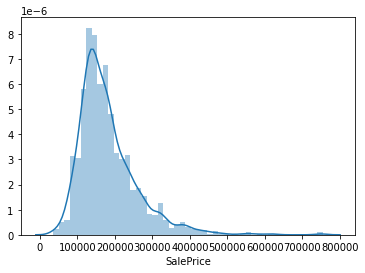

In [7]:
#histogram
sns.distplot(df['SalePrice']);

##### We can see that the target variable shows a slight deviation from normality, with a right skew and peakedness of the data. We will deal with it later.

#### `Price3Classes` - Finite set of class labels

In [8]:
df2 = df.groupby(['Price3Classes']).size().reset_index(name='Number').sort_values(by='Number', ascending=False)
Price3Classes = df2['Price3Classes'].values
Number = df2['Number'].values
df2

,Price3Classes,Number
0,<200000,1025
2,"[200000,400000]",407
1,>400000,28


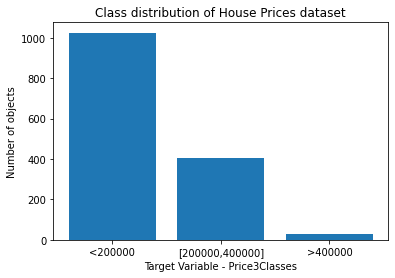

In [9]:
plt.figure() # <- makes a new figure and sets it active (add this)
plt.bar(Price3Classes, Number) # <- finds the current active axes/figure and plots to it
plt.title('Class distribution of House Prices dataset') 
plt.xlabel('Target Variable - Price3Classes')
plt.ylabel('Number of objects')
plt.show()

#### We can see that the target variable shows a dramatic class imbalance, that will have to be dealt with.

## Let's have a first look at how the numeric data is correlated, using a correlation matrix.

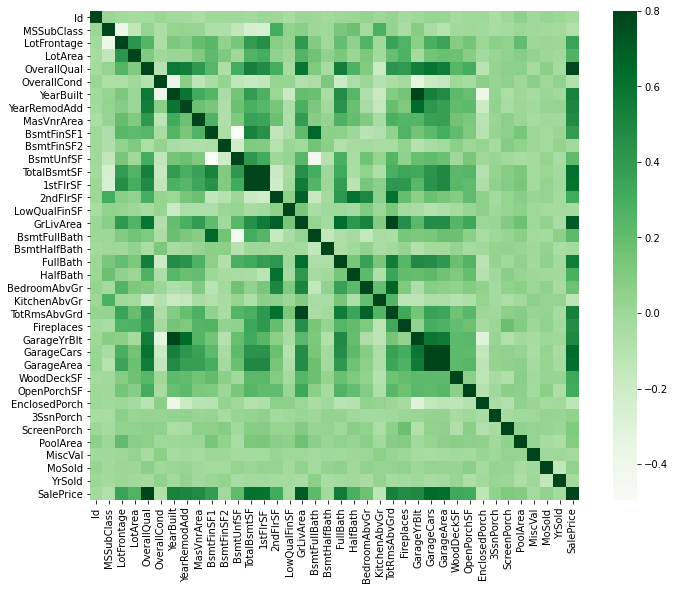

In [10]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='Greens');

- We can further explore these correlation, by looking at the correlation matrix with the target variable, `SalePrice`. 

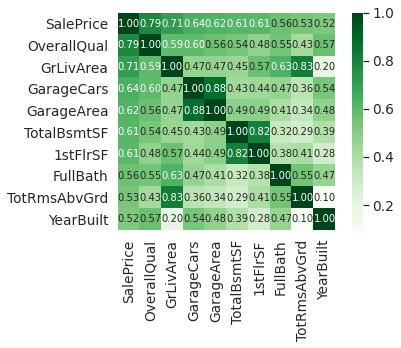

In [11]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap='Greens')
plt.show()

- We can already appreciate several features that seem to have a high correlation with `SalePrice`. We bet, these will turn out to be important later on, when we are selecting features for Classification and Regression.

# Feature engineering
- An essential step when dealing with a dataset, is to perform a bit of tinkering, in order to clean the dataset, and prepare it for being used in downstream analysis.

## Dealing with missing values
- We will first check which columns have missing values and deal with those.

In [12]:
pd.set_option('display.max_rows', 100)
delta =pd.DataFrame(df.isna().sum().sort_values(ascending=False).head(19)) #mostrar todas as variaveis com valores em falta
delta.columns = ["Number of NaN's"]

xiz = []
for i in delta["Number of NaN's"]:
    a = (i/len(df))*100
    xiz.append(a)
delta["Percentage of missing data"] = xiz
delta

,Number of NaN's,Percentage of missing data
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageQual,81,5.547945
GarageCond,81,5.547945
GarageFinish,81,5.547945
GarageType,81,5.547945


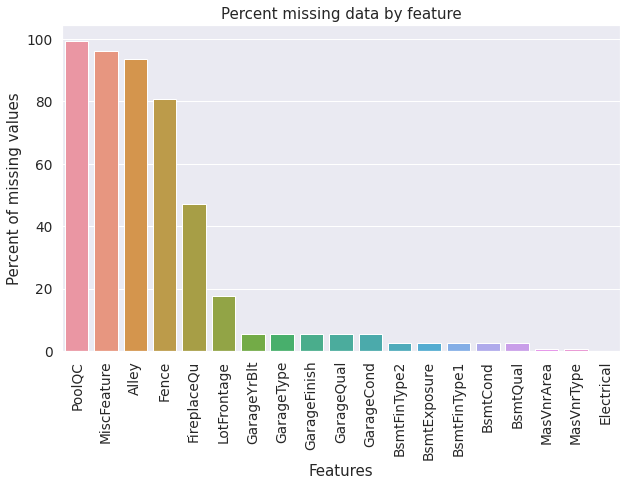

In [13]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

- As we can see, five of the attributes, have more than 40% of data missing. As such, we make the decision of simply eliminating these columns.

In [14]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True) 

- Now let's look at the other attributes and try to figure out how we should deal with the missing data in them.

In [15]:
pd.set_option('display.max_rows', 100)
delta = pd.DataFrame(df.isna().sum().sort_values(ascending=False).head(14))
delta.columns = ["Number of NaN's"]

xiz = []
for i in delta["Number of NaN's"]:
    a = (i/len(df))*100
    xiz.append(a)
delta["Percentage of missing data"] = xiz
delta

,Number of NaN's,Percentage of missing data
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtFinType1,37,2.534247
BsmtCond,37,2.534247


### What are all these columns refering to? Let's use the data description for each of the columns.
- LotFrontage: Linear feet of street connected to property
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageQual: Garage quality
- GarageCond: Garage condition
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinType1: Quality of basement finished area
- BsmtCond: General condition of the basement
- BsmtQual: Height of the basement
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- Electrical: Electrical system

- `LotFrontage` refers to the length of street connected to the property. For that reason, we will replace all NaN values by the median of the column.

In [16]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

- `GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual` and `GarageCond`, are columns describing the garage of the property. They all have the same number of missing values, so these values all seem to be related. Let's first visualize the type of data the columns contain.

In [17]:
print('GarageType:', set(df['GarageType'].values))
print('GarageYrBlt:', set(df['GarageYrBlt'].values))
print('GarageFinish:', set(df['GarageFinish'].values))
print('GarageQual:', set(df['GarageQual'].values))
print('GarageCond:', set(df['GarageCond'].values))

GarageType: {nan, '2Types', 'Attchd', 'CarPort', 'Basment', 'BuiltIn', 'Detchd'}
GarageYrBlt: {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1900.0, 1906.0, 1908.0, 1910.0, nan, nan, 1914.0, 1915.0, 1916.0, nan, 1918.0, nan, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976

- Looking at the data above, we are going to make changes to the NaN, for NA (not available). We are assuming here that NaN values correspond to the property not having a garage.

In [18]:
df['GarageType'].fillna('NA', inplace=True)
#df['GarageYrBlt'].fillna('NA', inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)

- We will also make a decision regarding the `GarageYrBlt`. As we don't believe that the year that the garage was built will be the deciding factor, but rather whether a garage actually exists (and its quality), we are taking the decision of removing the column, altogether.

In [19]:
df.drop('GarageYrBlt', axis=1, inplace=True) 

- `BsmtExposure`, `BsmtFinType2`, `BsmtFinType1`, `BsmtCond` and `BsmtQual` are attributes refering to the basement of the property. Let's look at the type of data they contain.

In [20]:
print('BsmtExposure:', set(df['BsmtExposure'].values))
print('BsmtFinType2:', set(df['BsmtFinType2'].values))
print('BsmtFinType1:', set(df['BsmtFinType1'].values))
print('BsmtCond:', set(df['BsmtCond'].values))
print('BsmtQual:', set(df['BsmtQual'].values))

BsmtExposure: {nan, 'Gd', 'Mn', 'No', 'Av'}
BsmtFinType2: {'Unf', nan, 'GLQ', 'Rec', 'BLQ', 'LwQ', 'ALQ'}
BsmtFinType1: {'Unf', 'GLQ', nan, 'Rec', 'BLQ', 'LwQ', 'ALQ'}
BsmtCond: {nan, 'Po', 'Gd', 'TA', 'Fa'}
BsmtQual: {nan, 'Gd', 'TA', 'Ex', 'Fa'}


- Similary to the data for the garage, they are all categorical values refering to the basement. We will assume again that a NaN refers to a non-existing basement and as such, we will substitute all NaN by a 'NA' (not available).

In [21]:
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)

- We next move to the `MasVnrType` and `MasVnrArea` columns. These columns refer to masonry veneer walls. Let's first check the set of values the column has.

In [22]:
print('MasVnrType:', set(df['MasVnrType'].values))
print('MasVnrArea:', set(df['MasVnrArea'].values))

MasVnrType: {nan, 'Stone', 'None', 'BrkFace', 'BrkCmn'}
MasVnrArea: {0.0, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, 11.0, 14.0, 16.0, 18.0, 22.0, 24.0, 27.0, 28.0, 30.0, 31.0, 32.0, 34.0, 36.0, 38.0, 40.0, 41.0, 42.0, 44.0, 45.0, 46.0, 48.0, 50.0, 51.0, 53.0, 54.0, 56.0, 57.0, 60.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 70.0, 72.0, 74.0, 75.0, 76.0, 80.0, 81.0, 82.0, 84.0, 85.0, 86.0, 88.0, 89.0, 90.0, 92.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 104.0, 105.0, 106.0, 108.0, 109.0, 110.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 119.0, 120.0, 122.0, 123.0, 125.0, 126.0, 127.0, 128.0, 130.0, 132.0, 135.0, 136.0, 137.0, 138.0, 140.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 153.0, 154.0, 156.0, 157.0, 158.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 174.0, 175.0, 176.0, 178.0, 180.0, 182.0, 183.0, 184.0, 186.0, 188.0, 189.0, 192.0, 194.0, 196.0, 200.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0

- The above values are categorical and area values. We checked that for each NaN of `MasVnrType`, we also have a NaN of `MasVnrArea`. As such, we will assume for the first, 'None" (as this is already a set of values in the column) and the second column, 0.

In [23]:
df['MasVnrType'].fillna('None', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

- We finally deal with our last column with NaN values, `Electrical`. This column has the following values:

In [24]:
print('Electrical:', set(df['Electrical'].values))
df['Electrical'].value_counts()

Electrical: {nan, 'SBrkr', 'FuseA', 'Mix', 'FuseF', 'FuseP'}


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

- `Electrical` has information about the type of electrical installation present in the property. As SBrkr (Standard Circuit Breakers & Romex installation) is by far the most common, we will assume that the NaN is a SBrkr.

In [25]:
df['Electrical'].fillna('SBrkr', inplace=True)

#### Is there still any missing data?

In [26]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


#### No, the missing data in the dataset, has been dealt with masterfully! 

## Correcting data types

- We next try to identify columns that have a wrong datatype. More precisely, columns that are numeric, but are actually categorical.
- We will also try to deal with ordinal and nominal categorical features.

In [27]:
# Let's identify the data type for all columns
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


- We have several quantitative and qualitative features. Let's have a closer look at each of them.

In [28]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']
qualitative.remove('Price3Classes')
print('Quantitative features are:')
print(quantitative)
print('\nQualitative features are:')
print(qualitative)

Quantitative features are:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Qualitative features are:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQu

- We can identify a few features that albeit having numerical values, are actually categoric. These include `MSSubClass`, `OverallQual`, `OverallCond`, `YearBuilt`, `YearRemodAdd`, `BsmtFullBath`, `BsmtHalfBath`, `FullBath`, `HalfBath`, `BedroomAbvGr`, `KitchenAbvGr`, `TotRmsAbvGrd`, `Fireplaces`, `GarageCars`, `MoSold` and `YrSold`.
- Most of these are actually ordinal and, as such, we will leave the features untouched.
- The only feature that has to be changed is `MSSubClass`, as it pertains to the type of dwelling involved in the sale and is a nominal categorical feature.

In [29]:
df2 = df.copy()
df2['MSSubClass'] = df2['MSSubClass'].astype(str)

In [30]:
# To use in case we decide to convert all categoric features to string.

#to_categorical = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
#for col in to_categorical: 
#    df[col] = df[col].astype(str)

## Dealing with nominal and ordinal categorical features

- The next step is slightly more demanding, as it requires going through the qualitative features and distinguish between ordinal and nominal features.

In [31]:
quantitative = [f for f in df.columns if df2.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df.columns if df2.dtypes[f] == 'object']
qualitative.remove('Price3Classes')
print('Quantitative features are:')
print(quantitative)
print('\nQualitative features are:')
print(qualitative)

Quantitative features are:
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Qualitative features are:
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQu

### From the description of the features, we can identify the following ordinal features:
- `LandSlope`, `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `HeatingQC`, `KitchenQual`, `Functional`, `FireplaceQu`, `GarageFinish`, `GarageQual`, `GarageCond`, `PoolQC`, `Fence`

### The following are nominal features:
- `MSSubClass`, `MSZoning`, `Street`, `Alley`, `LotShape`, `LandContour`, `Utilities`, `LotConfig`, `Neighborhood`, `Condition1`, `Condition2`, `BldgType`, `HouseStyle`, `RoofStyle`, `RoofMatl`, `Exterior1st`, `Exterior2nd`, `MasVnrType`, `Foundation`, `Heating`, `CentralAir`, `Electrical`, `GarageType`, `PavedDrive`, `MiscFeature`, `SaleType`, `SaleCondition`

## Dealing with the ordinal features

- Let's deal with ordinal features, by creating an index mapping for the ordinal features.

In [32]:
LandSlope_mapping = {'Sev': 3, 'Mod': 2,'Gtl': 1}
ExterQual_mapping = {'Ex': 5, 'Gd': 4,'TA': 3, 'Fa': 2, 'Po': 1}
ExterCond_mapping = {'Ex': 5, 'Gd': 4,'TA': 3, 'Fa': 2, 'Po': 1}
BsmtQual_mapping = {'Ex': 6, 'Gd': 5,'TA': 4, 'Fa': 3, 'Po': 2, 'NA': 1}
BsmtCond_mapping = {'Ex': 6, 'Gd': 5,'TA': 4, 'Fa': 3, 'Po': 2, 'NA': 1}
BsmtExposure_mapping = {'Gd': 5, 'Av': 4,'Mn': 3, 'No': 2, 'NA': 1}
BsmtFinType1_mapping = {'GLQ': 7, 'ALQ': 6,'BLQ': 5, 'Rec': 4, 'LwQ': 3, 'Unf': 2, 'NA': 1}
BsmtFinType2_mapping = {'GLQ': 7, 'ALQ': 6,'BLQ': 5, 'Rec': 4, 'LwQ': 3, 'Unf': 2, 'NA': 1}
HeatingQC_mapping = {'Ex': 5, 'Gd': 4,'TA': 3, 'Fa': 2, 'Po': 1}
KitchenQual_mapping = {'Ex': 5, 'Gd': 4,'TA': 3, 'Fa': 2, 'Po': 1}
Functional_mapping = {'Typ': 8, 'Min1': 7,'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}
#FireplaceQu_mapping = {'Ex': 6, 'Gd': 5,'TA': 4, 'Fa': 3, 'Po': 2, 'NA': 1}
GarageFinish_mapping = {'Fin': 4, 'RFn': 3,'Unf': 2, 'NA': 1}
GarageQual_mapping = {'Ex': 6, 'Gd': 5,'TA': 4, 'Fa': 3, 'Po': 2, 'NA': 1}
GarageCond_mapping = {'Ex': 6, 'Gd': 5,'TA': 4, 'Fa': 3, 'Po': 2, 'NA': 1}
#PoolQC_mapping = {'Ex': 5, 'Gd': 4,'TA': 3, 'Fa': 2, 'NA': 1}
#Fence_mapping = {'GdPrv': 5, 'MnPrv': 4,'GdWo': 3, 'MnWw': 2, 'NA': 1}

df2['LandSlope'] = df2['LandSlope'].map(LandSlope_mapping)
df2['ExterQual'] = df2['ExterQual'].map(ExterQual_mapping)
df2['ExterCond'] = df2['ExterCond'].map(ExterCond_mapping)
df2['BsmtQual'] = df2['BsmtQual'].map(BsmtQual_mapping)
df2['BsmtCond'] = df2['BsmtCond'].map(BsmtCond_mapping)
df2['BsmtExposure'] = df2['BsmtExposure'].map(BsmtExposure_mapping)
df2['BsmtFinType1'] = df2['BsmtFinType1'].map(BsmtFinType1_mapping)
df2['BsmtFinType2'] = df2['BsmtFinType2'].map(BsmtFinType2_mapping)
df2['HeatingQC'] = df2['HeatingQC'].map(HeatingQC_mapping)
df2['KitchenQual'] = df2['KitchenQual'].map(KitchenQual_mapping)
df2['Functional'] = df2['Functional'].map(Functional_mapping)
#df2['FireplaceQu'] = df2['FireplaceQu'].map(FireplaceQu_mapping)
df2['GarageFinish'] = df2['GarageFinish'].map(GarageFinish_mapping)
df2['GarageQual'] = df2['GarageQual'].map(GarageQual_mapping)
df2['GarageCond'] = df2['GarageCond'].map(GarageCond_mapping)
#df2['PoolQC'] = df2['PoolQC'].map(PoolQC_mapping)
#df2['Fence'] = df2['Fence'].map(Fence_mapping)

## Encoding class labels for `Price3Classes`

- A good practice in data classification and regression is to provide class labels as interger arrays, helping to avoid problems with estimators that can't deal well with strings.
- Let's do this, using the `LabelEncoder` from scikit learn.

In [33]:
# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()
df2['Price3Classes'] = class_le.fit_transform(df2['Price3Classes'].values)

In [34]:
set(df2['Price3Classes'])

{0, 1, 2}

In [35]:
list(class_le.inverse_transform([0, 1, 2]))

['<200000', '>400000', '[200000,400000]']

## Dealing with the remaining categorical nominal features

- The following features are nominal and can't be ordered or grouped.
- As such, we will resort to the `get_dummies` to convert categorical nominal features into dummy/indicator variables.

In [36]:
dfDummies = pd.get_dummies(df2)

columns = [f for f in dfDummies.columns]
column_names = ['Id', 'LotFrontage', 'LotArea', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_NA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial', 'SalePrice', 'Price3Classes']
dfDummies = dfDummies.reindex(columns=column_names)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(dfDummies)

,Id,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,Price3Classes
0,1,65.0,8450,1,7,5,2003,2003,196.0,4,3,5,4,2,7,706,2,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,3,2,548,4,4,0,61,0,0,0,0,0,2,2008,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0

#### We now have a dataset with no missing data, in which the categorical features have been dealt with. 

## Creating separate datasets for Classification and Regression.
- We will next create two datasets to analyze separately for Classification and Regression. 

### Regression dataset
- Let's reload the transformed and engineered dataframe, into a new set of variables to use in our tests.
- This will be the dataset we will use for our regression exercises.

In [37]:
def transform_df(df):
    """This function will transform the transformed dataframe into all the matrixes and arrays
    needed for downstream analysis.
    Requires: A Pandas DataFrame.
    Ensures: A dataframe, a array matrix with the values of the dataframe, without target features, a matrix 
    with the values of the target features, the name of the features, and the target variables.
    """

    df = df
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, 1:nc-2] # get features ignoring saleID and the two target values, SalePrice and Price3Classes.
    table_y = matrix [:, nc-1] # get Price3Classes 
    table_z = matrix [:, nc-2] # get SalePrice           
    features_names = df.columns.values[1:nc-2] # get features names (headers of columns)
    target_y = df.columns.values[nc-1] # get target name y
    target_z = df.columns.values[nc-2] # get target name z
    return df, table_X, table_y, table_z, features_names, target_y, target_z

df_Reg, table_X_reg, table_y_reg, table_z_reg, features_names_reg, target_y_reg, target_z_reg = transform_df(dfDummies)
df_Reg

,Id,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,Price3Classes
0,1,65.0,8450,1,7,5,2003,2003,196.0,4,...,0,1,0,0,0,0,1,0,208500,2
1,2,80.0,9600,1,6,8,1976,1976,0.0,3,...,0,1,0,0,0,0,1,0,181500,0
2,3,68.0,11250,1,7,5,2001,2002,162.0,4,...,0,1,0,0,0,0,1,0,223500,2
3,4,60.0,9550,1,7,5,1915,1970,0.0,3,...,0,1,1,0,0,0,0,0,140000,0
4,5,84.0,14260,1,8,5,2000,2000,350.0,4,...,0,1,0,0,0,0,1,0,250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,1,6,5,1999,2000,0.0,3,...,0,1,0,0,0,0,1,0,175000,0
1456,1457,85.0,13175,1,6,6,1978,1988,119.0,3,...,0,1,0,0,0,0,1,0,210000,2
1457,1458,66.0,9042,1,7,9,1941,2006,0.0,5,...,0,1,0,0,0,0,1,0,266500,2
1458,1459,68.0,9717,1,5,6,1950,1996,0.0,3,...,0,1,0,0,0,0,1,0,142125,0


### Classification dataset
#### We will start by dealing with class imbalance, so that we can help the classifiers perform their work.
- As we remember, from the start of our notebook, there is a huge class imbalance within this dataset.

In [38]:
df2 = df_Reg.groupby(['Price3Classes']).size().reset_index(name='Number').sort_values(by='Number', ascending=False)
df2

,Price3Classes,Number
0,0,1025
2,2,407
1,1,28


- To deal with this, we will use the SMOTE function from imblearn. This function will perform over-sampling of under-represented classes.

In [42]:
table_X_reg

array([[6.500e+01, 8.450e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.000e+01, 9.600e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.800e+01, 1.125e+04, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [6.600e+01, 9.042e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.800e+01, 9.717e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [7.500e+01, 9.937e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [46]:
table_y_reg#.ravel()

array([2., 0., 2., ..., 2., 0., 0.])

In [48]:
sm = SMOTE(random_state=2)

table_X_bal, table_y_bal = sm.fit_sample(table_X_reg, table_y_reg.ravel())

dfBalanced = pd.DataFrame(table_X_bal, columns=features_names_reg)
dfBalanced['Price3Classes'] = table_y_bal
dfBalanced

AttributeError: 'SMOTE' object has no attribute '_validate_data'

- Using the SMOTE function, we manage to get an over-sampling of all of our classes, so that all have the same number of rows per class.
- SMOTE will generate new instances from existing minority cases, without changing the number of the over-represented class(es). 
- SMOTE doesn't perform a simple over-sampling: it takes samples of the feature space for each target class and its nearest neighbors, generating new samples that combine features of the target case, with those from its neigbhors.

#### After all this process is finished, we end up with a equal number of objects per class.

In [36]:
p3c = (pd.DataFrame(table_y_bal, columns=[target_y_reg])).groupby(['Price3Classes']).size().reset_index(name='Number').sort_values(by='Number', ascending=False)
Price3Classes = p3c['Price3Classes'].values
Number = p3c['Number'].values
p3c

,Price3Classes,Number
0,0.0,1025
1,1.0,1025
2,2.0,1025


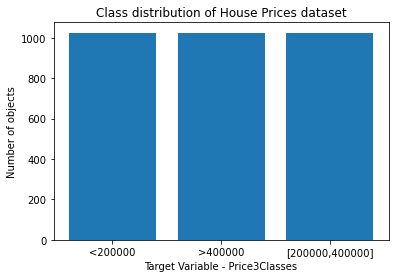

In [37]:
plt.figure() # <- makes a new figure and sets it active (add this)
plt.bar(list(class_le.inverse_transform([0, 1, 2])), Number) # <- finds the current active axes/figure and plots to it
plt.title('Class distribution of House Prices dataset') 
plt.xlabel('Target Variable - Price3Classes')
plt.ylabel('Number of objects')
plt.show()

### Finalizing the classification dataset
- Let's reload the transformed and engineered dataframe, into a new set of variables to use in our tests.
- This will be the dataset we will use for our classification exercises.

In [38]:
def transform_df(df):
    """This function will transform the transformed dataframe into all the matrixes and arrays
    needed for downstream analysis.
    Requires: A Pandas DataFrame.
    Ensures: A dataframe, a array matrix with the values of the dataframe, without target feature, a matrix 
    with the values of the target feature, the name of the features, and the target variable.
    """

    df = df
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, 0:nc-1] # get features ignoring saleID and the two target values, SalePrice and Price3Classes.
    table_y = matrix [:, nc-1] # get Price3Classes 
    features_names = df.columns.values[0:nc-1] # get features names (headers of columns)
    target_y = df.columns.values[nc-1] # get target name y
    return df, table_X, table_y, features_names, target_y

df_Clas, table_X_Clas, table_y_Clas, features_names_Clas, target_y_Clas = transform_df(dfBalanced)
df_Clas

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Price3Classes
0,65.000000,8450.000000,1.0,7.000000,5.000000,2003.000000,2003.000000,196.000000,4.000000,3.0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,2.0
1,80.000000,9600.000000,1.0,6.000000,8.000000,1976.000000,1976.000000,0.000000,3.000000,3.0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0
2,68.000000,11250.000000,1.0,7.000000,5.000000,2001.000000,2002.000000,162.000000,4.000000,3.0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,2.0
3,60.000000,9550.000000,1.0,7.000000,5.000000,1915.000000,1970.000000,0.000000,3.000000,3.0,...,0.000000,0.0,1.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,84.000000,14260.000000,1.0,8.000000,5.000000,2000.000000,2000.000000,350.000000,4.000000,3.0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070,81.960430,11758.721289,1.0,8.490108,5.000000,2007.019785,2007.019785,384.602580,4.490108,3.0,...,0.509892,0.0,0.490108,0.0,0.0,0.0,0.0,0.490108,0.509892,2.0
3071,35.202635,4646.695648,1.0,8.000000,5.000000,2005.140975,2005.140975,89.445061,4.000000,3.0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,2.0
3072,79.673668,11629.218886,1.0,9.000000,3.561187,2006.357230,2006.877625,460.323902,4.000000,3.0,...,0.479604,0.0,0.520396,0.0,0.0,0.0,0.0,0.520396,0.479604,2.0
3073,78.004089,9459.393814,1.0,7.600818,5.000000,1993.000000,1993.600818,129.790187,4.000000,3.0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,2.0


# Feature Selection
Feature selection is an essential step of the data mining process. It basically consists of automatically or manually selecting the features that contribute the most to predict our target variable(s) or outputs we are interested in. It is a bit of a mystical art, where expertise, statistics, data type, target variables, all combine to provide a solution... not the best solution, but a solution that can produce desirable outcomes and that, more often than not, demand to be revised and adjusted.
In any case, the efforts towards feature selection should focus on reduction of redundant data (and therefore, noise), reduction of misleading data to improve accuracy of the estimators and selection of the minimum number of features that reduce the complexity of algorithms, with compromising their efficiency.

With this in mind, we will use a combination of supervised techniques, to help us select a number of features that we think will provide us with a both compromise for the exercise.

We will resort to:
1. Correlation Matrix with Heatmap
2. Feature Importance
3. Univariate Selection

In fact, we already visualized correlation matrixes and heatmaps at the beggining of this notebook. This allowed us to identify interesting features, like: `OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`, `FullBath`, `TotRmsAbvGrd`, `YearBuilt`. Looking at them, we can see how they actually make lots of sense and would certainly be features we would choose, if we were real-estate agents!

## Feature Selection for Regression
### Feature Selection using Random Forest - Selecting features based on their importance
- Random Forests consist of a variable number of decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Each tree is a sequence of yes-no questions, based on a single or combination of features. At each node, the tree is divided into 2 buckets, where observations that are more simnilar among themselves (and dissimilar from others) are "stored". The importance of each feature is derived from how "pure" each of the buckets is.

In [39]:
feat_labels = features_names_reg

forest = RandomForestRegressor(n_estimators=500,
                                random_state=1)

forest.fit(table_X_reg, table_z_reg)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(table_X_reg.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) OverallQual                    0.581397
 2) GrLivArea                      0.108843
 3) TotalBsmtSF                    0.039167
 4) 2ndFlrSF                       0.035321
 5) BsmtFinSF1                     0.026853
 6) 1stFlrSF                       0.021632
 7) GarageCars                     0.018939
 8) GarageArea                     0.015349
 9) LotArea                        0.012498
10) YearBuilt                      0.009892
11) YearRemodAdd                   0.007993
12) TotRmsAbvGrd                   0.007327
13) LotFrontage                    0.006956
14) BsmtQual                       0.006222
15) FullBath                       0.005904
16) BsmtUnfSF                      0.005690
17) WoodDeckSF                     0.004905
18) KitchenQual                    0.004756
19) OpenPorchSF                    0.004550
20) MasVnrArea                     0.004469
21) GarageFinish                   0.004173
22) OverallCond                    0.004149
23) MoSold                      

- Let's visualize the importance of each feature in a histogram.

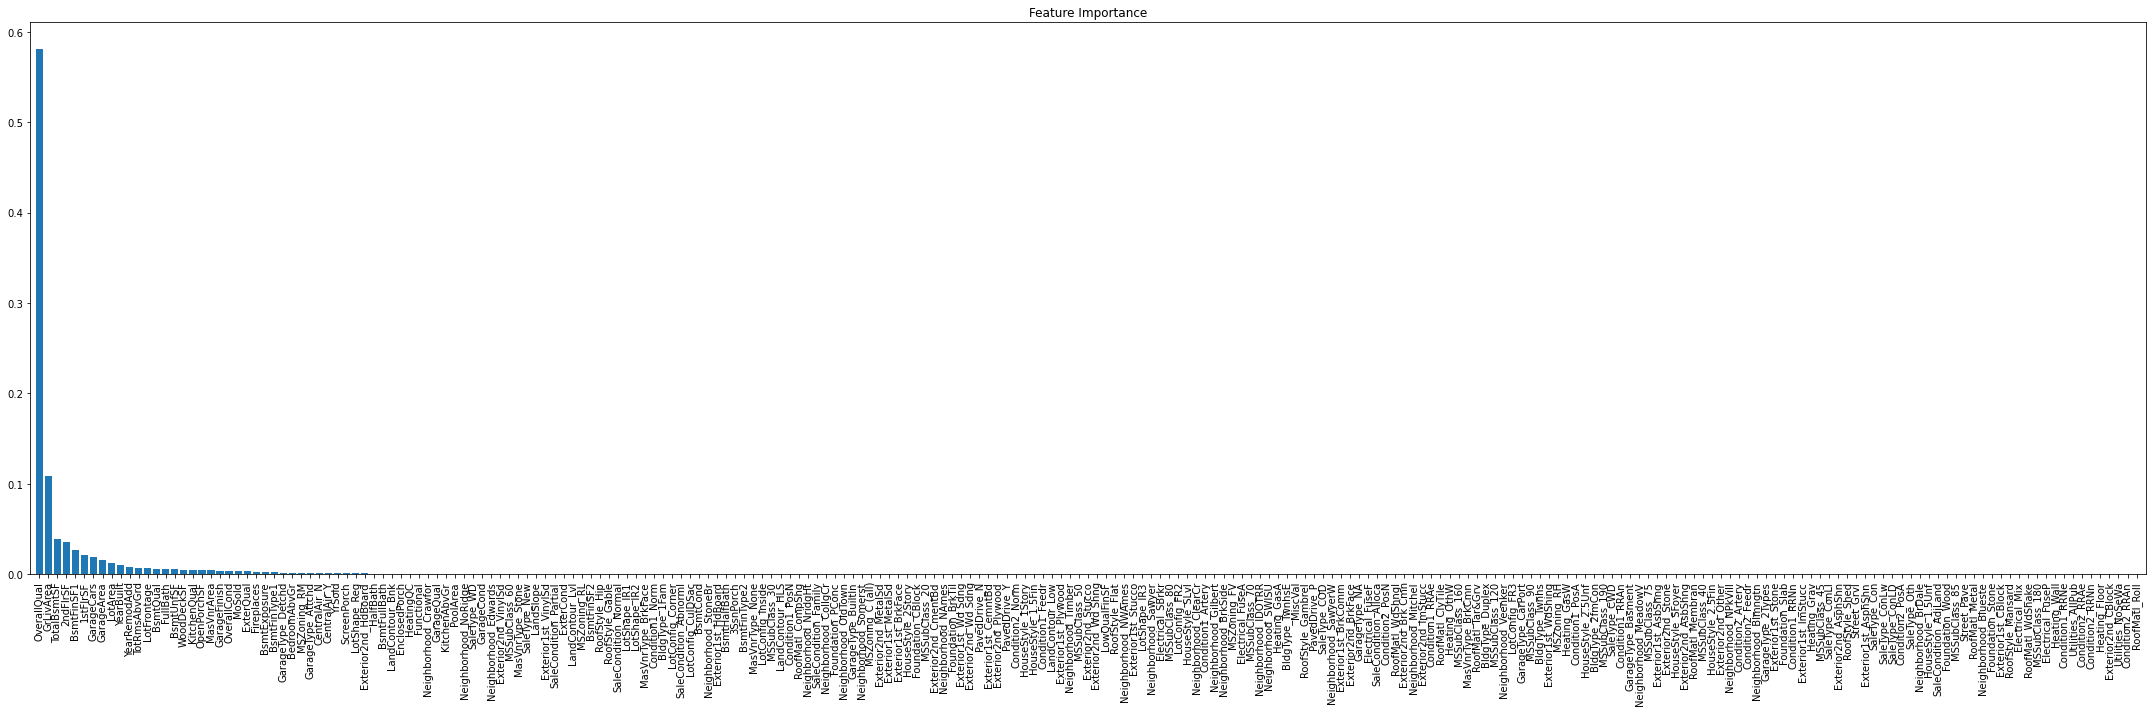

In [40]:
plt.figure(figsize=(30,10))
plt.title('Feature Importance')

plt.bar(range(table_X_reg.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(table_X_reg.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, table_X_reg.shape[1]])
plt.tight_layout()
plt.show()

- The Random Forest Regressor is attributing a too big importance to the `OverallQual` feature. Although it makes sense that it is one of the most important features in determining `SalePrice`, it seems to be giving an excessive importance to this variable, that "masks" all other features. Let's turn to univariate feature selection.

### Univariate Feature Selection
- Using statistical tests, we can select the features that have the strongest relationship with the target variable.
- For regression, we will use the `chi2`, `f_regression` and `mutual_info_regression` metrics.

In [41]:
t1 = table_X_reg
t2 = table_z_reg

chi2_score, chi_2_p_value = chi2(t1, t2)
fr_score, fr_p_value = f_regression(t1, t2)
mutual_info_regression_score = mutual_info_regression(t1, t2)

dfScores=pd.DataFrame({"names": features_names_reg, 
                "chi2": chi2_score,
                "chi2_p": chi_2_p_value,
                "Fr": fr_score,
                "Fr_p": fr_p_value,
                "MIr": mutual_info_regression_score})

In [42]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#    display(dfScores.sort_values(by=['Fr'], ascending=False))
    
dfScores.sort_values(by=['Fr'], ascending=False).head(40)

,names,chi2,chi2_p,Fr,Fr_p,MIr
3,OverallQual,378.077635,1.000000e+00,2436.770591,2.185675e-313,0.576633
23,GrLivArea,196850.057866,0.000000e+00,1470.585010,4.518034e-223,0.484500
8,ExterQual,107.114880,1.000000e+00,1272.318336,7.331707e-201,0.335210
30,KitchenQual,132.134649,1.000000e+00,1122.858910,5.051357e-183,0.318996
35,GarageCars,324.554492,1.000000e+00,1013.705666,2.498644e-169,0.361468
36,GarageArea,96184.054050,0.000000e+00,926.951287,5.265038e-158,0.360427
18,TotalBsmtSF,174706.462874,0.000000e+00,880.341282,9.484229e-152,0.368761
20,1stFlrSF,123809.831341,0.000000e+00,845.524488,5.394711e-147,0.311347
10,BsmtQual,178.640917,1.000000e+00,759.380775,6.512989e-135,0.332322
26,FullBath,195.208250,1.000000e+00,668.430296,1.236470e-121,0.251463


- As we can observe, from the combined approaches above, there are clearly a handful of features that are obviously quite correlated with the target variable, `SalesPrice`.
- Amongst these, the following features are clearly standing out:  `OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`, `FullBath`, `TotRmsAbvGrd`, `YearBuilt`.
- The decision of an adequate number of features to select is not trivial, as discussed above. Given the combined analysis of our results, we made the decision of selecting the 40 best features, by `f_regression` score.

- We thus, created a new dataset with only the 40 selected features, and transformed the produced dataframe into all set of arrays and matrixes required for the regression exercises.

In [43]:
delta = dfScores.sort_values(by=['Fr'], ascending=False)
nwer =list(delta['names'].values)[:40]
X = pd.DataFrame(table_X_reg, columns = feat_labels)
dfRegression = X[nwer]
dfRegression['SalePrice'] = table_z_reg

In [44]:
def transform_df(df):
    """This function will transform the transformed dataframe into all the matrixes and arrays
    needed for downstream analysis.
    Requires: A Pandas DataFrame.
    Ensures: A dataframe, a array matrix with the values of the dataframe, without target features, a matrix 
    with the values of the target features, the name of the features, and the target variables.
    """

    df = df
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, :nc-1] # get features ignoring SalePrice.
    table_y = matrix [:, nc-1] # get SalePrice 
    features_names = df.columns.values[0:nc-1] # get features names (headers of columns)
    target_y = df.columns.values[nc-1] # get target name y
    return df, table_X, table_y, features_names, target_y

dfRegression, table_X_regression, table_y_regression, features_names_regression, target_y_regression = transform_df(dfRegression)
dfRegression

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,...,WoodDeckSF,2ndFlrSF,OpenPorchSF,Exterior2nd_VinylSd,Exterior1st_VinylSd,BsmtFinType1,MSZoning_RM,HalfBath,GarageQual,SalePrice
0,7.0,1710.0,4.0,4.0,2.0,548.0,856.0,856.0,5.0,2.0,...,0.0,854.0,61.0,1.0,1.0,7.0,0.0,1.0,4.0,208500.0
1,6.0,1262.0,3.0,3.0,2.0,460.0,1262.0,1262.0,5.0,2.0,...,298.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,181500.0
2,7.0,1786.0,4.0,4.0,2.0,608.0,920.0,920.0,5.0,2.0,...,0.0,866.0,42.0,1.0,1.0,7.0,0.0,1.0,4.0,223500.0
3,7.0,1717.0,3.0,4.0,3.0,642.0,756.0,961.0,4.0,1.0,...,0.0,756.0,35.0,0.0,0.0,6.0,0.0,0.0,4.0,140000.0
4,8.0,2198.0,4.0,4.0,3.0,836.0,1145.0,1145.0,5.0,2.0,...,192.0,1053.0,84.0,1.0,1.0,7.0,0.0,1.0,4.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6.0,1647.0,3.0,3.0,2.0,460.0,953.0,953.0,5.0,2.0,...,0.0,694.0,40.0,1.0,1.0,2.0,0.0,1.0,4.0,175000.0
1456,6.0,2073.0,3.0,3.0,2.0,500.0,1542.0,2073.0,5.0,2.0,...,349.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,210000.0
1457,7.0,2340.0,5.0,4.0,1.0,252.0,1152.0,1188.0,4.0,2.0,...,0.0,1152.0,60.0,0.0,0.0,7.0,0.0,0.0,4.0,266500.0
1458,5.0,1078.0,3.0,4.0,1.0,240.0,1078.0,1078.0,4.0,1.0,...,366.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,4.0,142125.0


## Feature Selection for Classification
- We will perform the same analysis as the one above, but focusing on strategies suited for classification.

### Feature Selection using Random Forest - Selecting features based on their importance
- Let's calculate the importance of each feature for the target varible `Price3Classes`.

In [45]:
feat_labels = features_names_Clas

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(table_X_Clas, table_y_Clas)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(table_X_Clas.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) OverallQual                    0.083223
 2) GrLivArea                      0.076264
 3) KitchenQual                    0.064159
 4) ExterQual                      0.057565
 5) 1stFlrSF                       0.043177
 6) TotalBsmtSF                    0.042940
 7) TotRmsAbvGrd                   0.042236
 8) LotArea                        0.036587
 9) BsmtQual                       0.034467
10) GarageCars                     0.032508
11) GarageArea                     0.032199
12) FullBath                       0.022228
13) Foundation_PConc               0.020032
14) MasVnrArea                     0.018023
15) YearBuilt                      0.017268
16) SaleType_New                   0.016838
17) YearRemodAdd                   0.015559
18) 2ndFlrSF                       0.015481
19) GarageFinish                   0.014320
20) OpenPorchSF                    0.013789
21) Fireplaces                     0.013677
22) BsmtFinSF1                     0.012694
23) SaleCondition_Partial       

- Let's visualize the importance of each feature in a histogram.

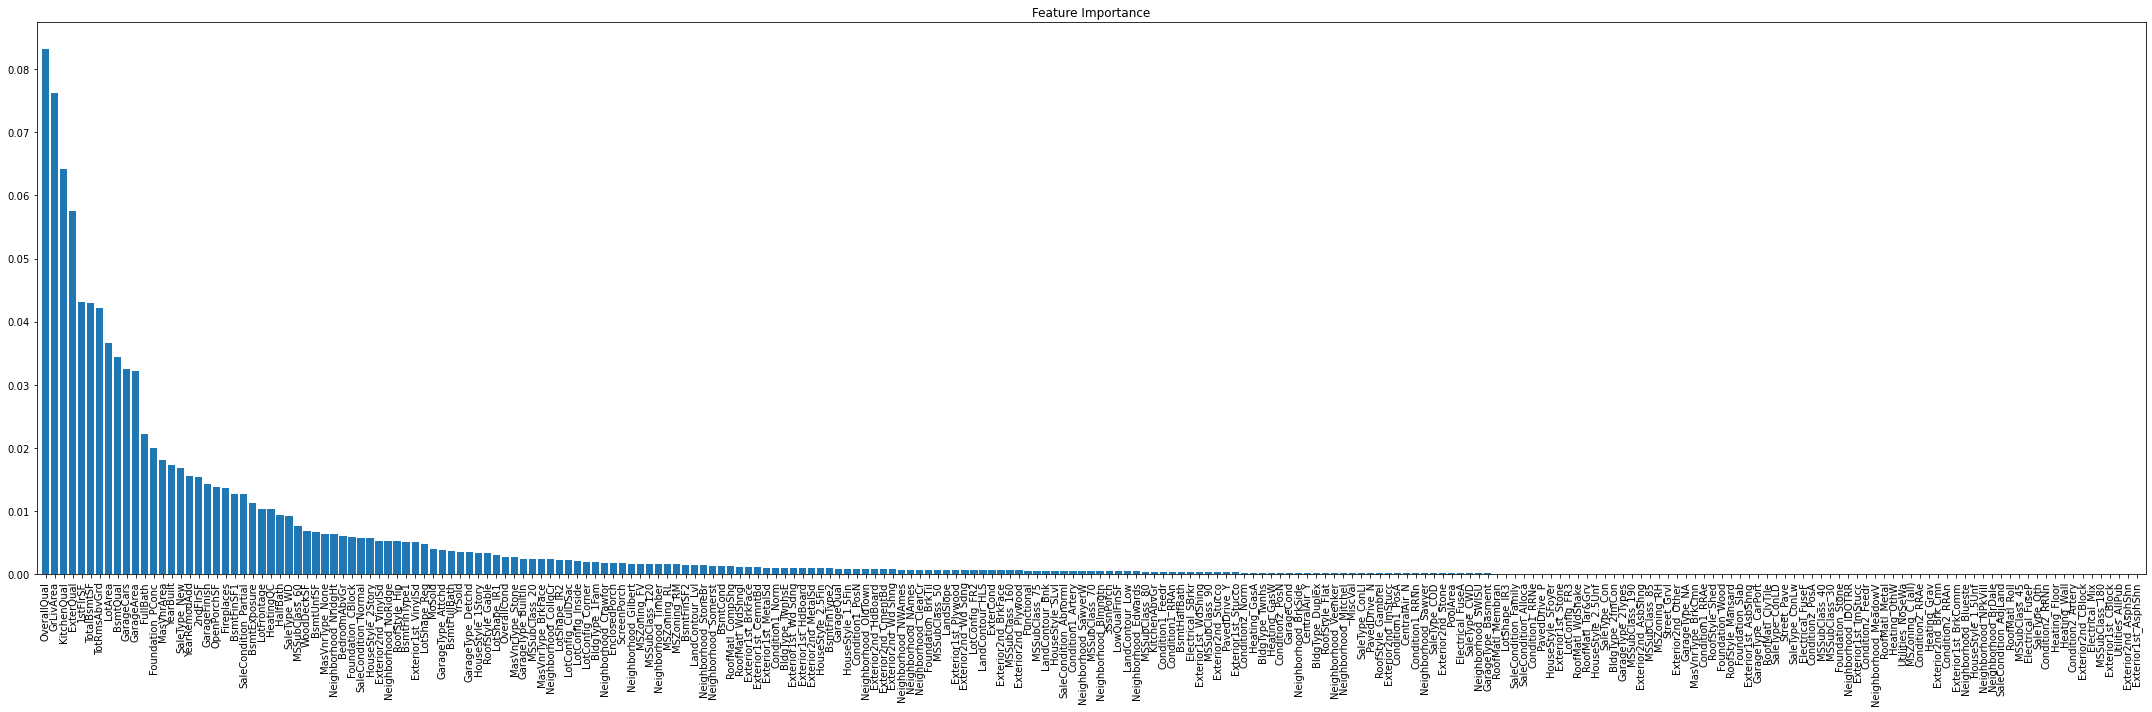

In [46]:
plt.figure(figsize=(30,10))
plt.title('Feature Importance')

plt.bar(range(table_X_Clas.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(table_X_Clas.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, table_X_Clas.shape[1]])
plt.tight_layout()
plt.show()

### Univariate Feature Selection
- Using statistical tests, we can select the features that have the strongest relationship with the target variable.
- For classification, we will use the `chi2`, `f_classif` and `mutual_info_classif` metrics.

In [47]:
t1 = table_X_Clas
t2 = table_y_Clas

chi2_score, chi_2_p_value = chi2(t1, t2)
f_score, f_p_value = f_classif(t1, t2)
mut_info_score = mutual_info_classif(t1, t2)

dfScores=pd.DataFrame({"names": features_names_Clas, 
                "chi2": chi2_score,
                "chi2_p": chi_2_p_value,
                "F": f_score,
                "F_p": f_p_value,
                "MI": mut_info_score})

In [48]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(dfScores.sort_values(by=['MI'], ascending=False))
   
dfScores.sort_values(by=['MI'], ascending=False).head(40)

,names,chi2,chi2_p,F,F_p,MI
3,OverallQual,9.126284e+02,6.687348e-199,4459.694336,0.000000e+00,0.756371
30,KitchenQual,2.890071e+02,1.749424e-63,2798.777940,0.000000e+00,0.604595
23,GrLivArea,5.551032e+05,0.000000e+00,2822.679984,0.000000e+00,0.602904
31,TotRmsAbvGrd,8.956959e+02,3.177619e-195,2109.657058,0.000000e+00,0.575464
8,ExterQual,2.603617e+02,2.905163e-57,2815.207373,0.000000e+00,0.574072
36,GarageArea,1.453619e+05,0.000000e+00,1926.429870,0.000000e+00,0.546252
35,GarageCars,4.786147e+02,1.175280e-104,2265.142500,0.000000e+00,0.537760
10,BsmtQual,2.382216e+02,1.865667e-52,1535.500339,0.000000e+00,0.516533
18,TotalBsmtSF,3.994933e+05,0.000000e+00,2051.680889,0.000000e+00,0.514762
6,YearRemodAdd,1.783730e+02,1.848404e-39,933.424704,1.861128e-317,0.468928


- Similarly to what we observed before, we can observe several features that are strongly correlated to the target class `Price3Classes`.
- Unlike for `SalesPrice`, the features dependency/importance, is more heterogeneous and one can clearly see a set of more important features. 
- Nevertheless, for the sake of this academic exercise, we decided to take a similar approach for selecting features for classification, by selecting the 40 best features, by `MI` score.

In [49]:
epsilon = dfScores.sort_values(by=['MI'], ascending=False)
nwer = list(epsilon['names'].values)[:40]
X = pd.DataFrame(table_X_Clas, columns = feat_labels)
dfClassif = X[nwer]
dfClassif['Price3Classes'] = table_y_Clas

In [50]:
def transform_df(df):
    """This function will transform the transformed dataframe into all the matrixes and arrays
    needed for downstream analysis.
    Requires: A Pandas DataFrame.
    Ensures: A dataframe, a array matrix with the values of the dataframe, without target features, a matrix 
    with the values of the target features, the name of the features, and the target variables.
    """

    df = df
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, :nc-1] # get features ignoring Price3Classes.
    table_y = matrix [:, nc-1] # get Price3Classes 
    features_names = df.columns.values[0:nc-1] # get features names (headers of columns)
    target_y = df.columns.values[nc-1] # get target name y
    return df, table_X, table_y, features_names, target_y

dfClassification, Classif_X, Y_table, features_names_classification, target_y_classification = transform_df(dfClassif)
dfClassification

,OverallQual,KitchenQual,GrLivArea,TotRmsAbvGrd,ExterQual,GarageArea,GarageCars,BsmtQual,TotalBsmtSF,YearRemodAdd,...,RoofStyle_Hip,SaleType_WD,MSSubClass_60,MasVnrType_None,RoofStyle_Gable,Neighborhood_NridgHt,HalfBath,HouseStyle_2Story,Exterior2nd_VinylSd,Price3Classes
0,7.000000,4.000000,1710.000000,8.000000,4.000000,548.000000,2.00000,5.0,856.000000,2003.000000,...,0.0,1.000000,1.00000,0.000000,1.0,0.000000,1.000000,1.00000,1.000000,2.0
1,6.000000,3.000000,1262.000000,6.000000,3.000000,460.000000,2.00000,5.0,1262.000000,1976.000000,...,0.0,1.000000,0.00000,1.000000,1.0,0.000000,0.000000,0.00000,0.000000,0.0
2,7.000000,4.000000,1786.000000,6.000000,4.000000,608.000000,2.00000,5.0,920.000000,2002.000000,...,0.0,1.000000,1.00000,0.000000,1.0,0.000000,1.000000,1.00000,1.000000,2.0
3,7.000000,4.000000,1717.000000,7.000000,3.000000,642.000000,3.00000,4.0,756.000000,1970.000000,...,0.0,1.000000,0.00000,1.000000,1.0,0.000000,0.000000,1.00000,0.000000,0.0
4,8.000000,4.000000,2198.000000,9.000000,4.000000,836.000000,3.00000,5.0,1145.000000,2000.000000,...,0.0,1.000000,1.00000,0.000000,1.0,0.000000,1.000000,1.00000,1.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070,8.490108,4.490108,1976.894838,7.490108,4.490108,811.455053,3.00000,6.0,1976.894838,2007.019785,...,1.0,0.490108,0.00000,0.000000,0.0,0.000000,0.509892,0.00000,0.509892,2.0
3071,8.000000,4.000000,1516.890121,6.000000,4.000000,619.268775,2.00000,5.0,1516.890121,2005.140975,...,0.0,1.000000,0.00000,0.171805,1.0,0.828195,0.000000,0.00000,0.828195,2.0
3072,9.000000,5.000000,1822.694671,6.959208,4.000000,854.815831,3.00000,6.0,1822.694671,2006.877625,...,1.0,0.520396,0.00000,0.000000,0.0,0.520396,0.479604,0.00000,1.000000,2.0
3073,7.600818,4.000000,1856.711218,7.600818,4.000000,452.637618,2.00000,5.0,762.230258,1993.600818,...,0.0,1.000000,1.00000,0.000000,1.0,0.000000,1.000000,1.00000,0.600818,2.0


## Summarizing our pre-processing step:
- We created two separate datasets, one for regression, one for classification.
- The produced datasets have no missing values, and categorical nominal features were encoded into a OHE format.
- We selected the 40 top features using univariate feature selection, and a combination of feature importance and correlation matrixes.
- The classification dataset was over-sampled to compensate for class imbalance.

#### There are things that we didn't do, that could have been done to further maximize the efficiency of the models:
- Standardize the numerical features using, for example, `StandardScaler`.
- Transform numerical variables to deal with skewness from a normal distribution.
- Apply SMOTE in the regression dataset, to compensate for the lack of houses with high prices (that indeed, posed some problems to the regressors).
- Deal with outliers and deal with features that show colinearity (there are several features that seem to be highly correlated and, as such, losing one would decrease noise and the chance of overfitting the models).

#### NOTE: There is a mistake we believe we have performed with the classification dataset. Namely, applying the SMOTE function on all of the classification dataset, prior to separating it into train and test sets. We wanted to correct this, by balancing only the training set, but did not have the time to perform this task. We are aware that this is not perfect, as the test set is filled with "synthetic" data, but we didn't have time to tackle this issue.

## 2. Learning Simple Classifiers

* Choose **`X` classifiers** (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
* Use **grid-search and stratified 10 fold cross-validation** to estimate the best parameters (https://scikit-learn.org/stable/model_selection.html#model-selection). 
* Present mean and standard deviation of accuracy, precision and recall.
* Show confusion matrices.

#### Classification is a data mining function that assigns objects in a dataset to a target class or variable. The ultimate goal of classifier algorithms, is to build a model to accurately predict the target class for each case in the dataset. In this exercise, the goal of the classifiers is to be able to attribute a class to a given object, by "looking" at its set of features.

In this section, we split the classification dataset into training and testing matrixes and use them with 3 classifiers from scikit-learn, **K-Nearest Neighbors**, **Gaussian Naive Bayes** and **Decision Trees**. For determining the best parameters for the different algorithms, we use a `GridSearchCV` and stratified 10-fold cross-validation strategy. Finally, we use several metrics to evaluate the classification models, like accuracy (ratio of correct classification), precision (ratio of correct positive classification over total predicted positives), recall (ratio of correct positives over total positives) and F1 scores (harmonic mean of precision and recall), as well as Matthews correlation coefficient (MCC). The MCC is, in fact, a more reliable statistical measure that produces high scores only if the predictions achieve good results for all categories of the confusion matrix (true positives, false negatives, true negatives and false positives).

### Producing the classifier train and test sets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(Classif_X, Y_table, test_size=0.2, stratify=Y_table, random_state=1)
print('Number of rows for training:', len(X_train))
print('Number of rows for testing:', len(X_test))
print('\nTrue labels:', len(y_test))

Number of rows for training: 2460
Number of rows for testing: 615

True labels: 615


# K Nearest Neighbors Classifier

The k-nearest Neighbors algorithm (k-NN) is a non-parametric method that can be used for both classification and regression (and in fact, we will use it for both exercises). The k-NN takes as an input the k closest training examples in the feature space. For classification, the algorithm provides the class to which each object belongs. This object is classified by the plurality of votes of its neighbors, being assigned to the class that is dominant amongst its k nearest neigbhors.

Let's first run our `GridsearchCV` with 10-fold cross-validation, to try to tune the hyperparameters for the algorithm.
- We test the parameters n_neigbors, algortihm, weights and leaf_size.

In [52]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

parameters = dict(n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  algorithm=['auto','brute', 'kd_tree', 'ball_tree'],
                  weights=['uniform','distance'],
                  leaf_size=[10,20,30,40,50])

gs_KNNc = GridSCV(KNN, parameters, X_train, y_train, matthews_corrcoef)

Best score: 0.8929465705764494
Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 1, 'weights': 'uniform'}
Cross Validation score: 0.889 +/- 0.018


- The best combination of parameters was algorithm: 'auto', leaf_size: 10, n_neighbors: 1, weights: 'uniform'.
- Considering that the number of neighbors indicate the number of objects close in the dimensional space to object considered, if we use the number of neighbors of 1, this means that this model considers only the closest training point to the query point. A low value of `n_neighbors` contributes for the low bias to the model, so using the value of 1 in this parameter indicates a very low associated bias.

- We then use these parameters to run the k-NN and derive a model from the training set.
- We finally use the model to predict the classes of the objects in the test set and calculate the mislabeled objects and the metrics and confusion matrix to evaluate the efficiency of the classifier.

Mislabeled elements: 38
Precision: 0.940
Recall: 0.938


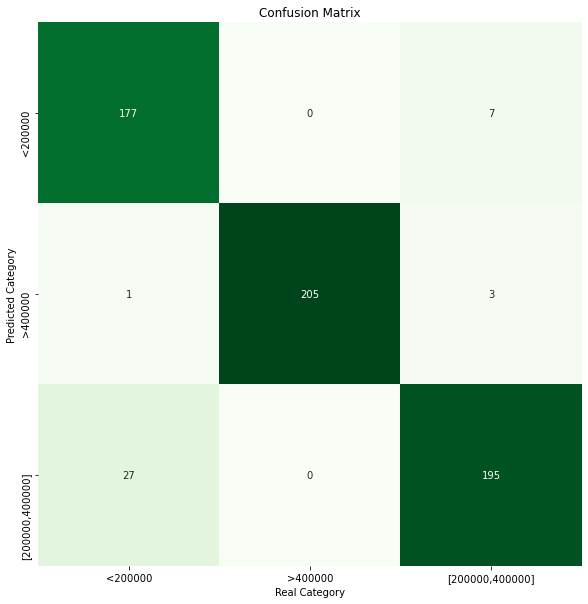

In [53]:
KNN = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=1, weights='uniform')
y_pred_KNN = KNN.fit(X_train, y_train).predict(X_test)

prediction_measures(y_test, y_pred_KNN)

confusionMatrix(y_test, y_pred_KNN)

In [54]:
scoring_metrics(y_test, y_pred_KNN)

Matthews correlation coefficient score (MCC):  0.9087

                  precision    recall  f1-score   support

        <200000       0.96      0.86      0.91       205
        >400000       0.98      1.00      0.99       205
[200000,400000]       0.88      0.95      0.91       205

       accuracy                           0.94       615
      macro avg       0.94      0.94      0.94       615
   weighted avg       0.94      0.94      0.94       615



#### As we can see, with our pre-processing and feature selection, we obtain fairly good predictions for the test set. The MCC score (and all other scores) are high and the class that shows lower scores is the `<200000` class. Likely because there is much more variability between the objects of this class (that are real), compared to the objects from the other classes (that were oversampled).

#  Gaussian Naive Bayes

Naive Bayes classifiers are a family of simple "probabilistic classifiers", that use the Bayes' theorem. This theorem "naively" assumes a strong independence between every pair of features. Naive Bayes classifiers can be extended to real-valued attributes, most commonly by assuming a Gaussian distribution. This is exactly the extension of Naive Bayes that we used, Gaussian Naive Bayes, that assume that the distribution of features is Gaussian.

We ran our `GridsearchCV` with 10-fold cross-validation, to try to tune the hyperparameters for the algorithm.
- For the Gaussian Naive Bayes, we only tested the var_smoothing parameter.

In [55]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

parameters = dict(var_smoothing=[1e-20,1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-5, 1e-3, 1e-2,1e-01])

gs_gnb = GridSCV(GNB, parameters, X_train, y_train, matthews_corrcoef)

Best score: 0.8575728410944825
Best parameters: {'var_smoothing': 1e-07}
Cross Validation score: 0.858 +/- 0.026


- The best parameter is var_smoothing: 1e-08
- We use this parameter to run the classifier on our training set and test sets (for predictions).

Mislabeled elements: 52
Precision: 0.916
Recall: 0.915


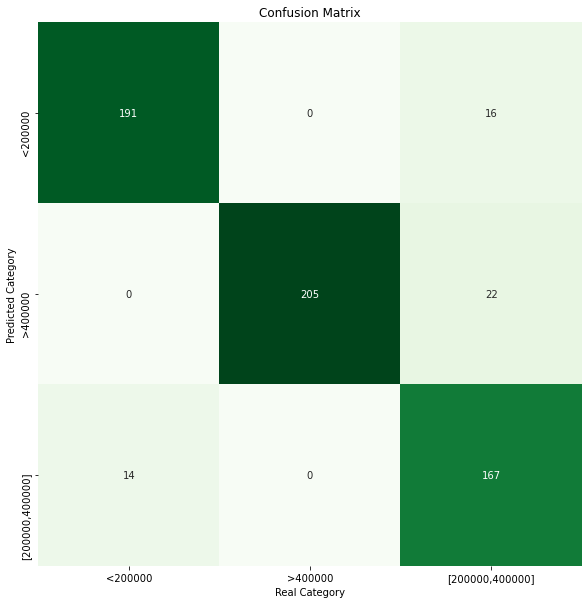

In [55]:
GNB = GaussianNB(var_smoothing=1e-7)
y_pred_GNB = GNB.fit(X_train, y_train).predict(X_test)

prediction_measures(y_test, y_pred_GNB)

confusionMatrix(y_test, y_pred_GNB)

In [56]:
scoring_metrics(y_test, y_pred_GNB)

Matthews correlation coefficient score (MCC):  0.8750

                  precision    recall  f1-score   support

        <200000       0.92      0.93      0.93       205
        >400000       0.90      1.00      0.95       205
[200000,400000]       0.92      0.81      0.87       205

       accuracy                           0.92       615
      macro avg       0.92      0.92      0.91       615
   weighted avg       0.92      0.92      0.91       615



#### Although this classifier gives good results, it falls slightly behind those from the k-NN classifier. Similarly, the class that has lower predictive scores is the `<200000`. 

#### Gaussian Naive Bayes Limitations 

This model proved to be able to make good classifications using the test set. However, it has a classification capacity lower than the capacity presented by K-Nearest Neighbors. It is possible that there are several limitations regarding this algorithm:
 
- First, this classification algorithm assumes a Gaussian distribution of the data. Considering that our data doesn't have a normal distribution, this type of assumption can introduce biases in the classification model.

- Secondly, as previously described, the Gaussian Naive Bayes model assumes strong independence between pairs of features. This assumption also does not apply to our features considering that not all pairs of features are independent. Consider, for example, the variables `GarageCars` and `GarageArea`, or `TotalBsmtSF` and `1stFlrSf`, that we have been in the correlation matrixes in the beginning of this notebook, to be highly correlated.

# Decision Tree Classifier

Decision trees are simple representations used for classifying examples. It is a very popular technique in supervised machine learning, where data is split according to certain parameters. The decision tree is used, as a predictive model, that go from questions/tests about a value of certain attributes (represented by nodes), to observations about objects (that are represented in the branches), to conclusions about the target value for that object (represented in the leaves of the tree). 
Decision trees can be used for both classification and regression. In the case of classification, the leaves of the trees represent the class labels, whereas the branches represent the set of features that lead to those class labels.

We ran `GridsearchCV` with 10-fold cross-validation, to try to tune the hyperparameters for the algorithm.
- For the Decision Tree Classifier, we tested the max_depth, criterion, splitter, min_samples_split, min_samples_leaf and presort parameters.

In [58]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

parameters = dict(max_depth=[0.5, 1, 2, 3, 4, 5, None],
                  criterion=['gini','entropy'],
                  splitter=['best','random'],
                  min_samples_split=[0.25,0.5,0.75,1.0],
                  min_samples_leaf=[1,2,3,4],
                  presort=[True,False])

gs_dtc = GridSCV(DTC, parameters, X_train, y_train, matthews_corrcoef)

Best score: 0.8731164268129465
Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 0.25, 'presort': True, 'splitter': 'best'}
Cross Validation score: 0.869 +/- 0.027


- The best parameters obtained were: criterion: 'gini', max_dept: None, min_samples_leaf: 3, min_samples_split: 0.25, presort: True, splitter: 'best'.
- We use these parameter to run the classifier on our training set and test sets (for predictions).

Mislabeled elements: 62
Precision: 0.898
Recall: 0.899


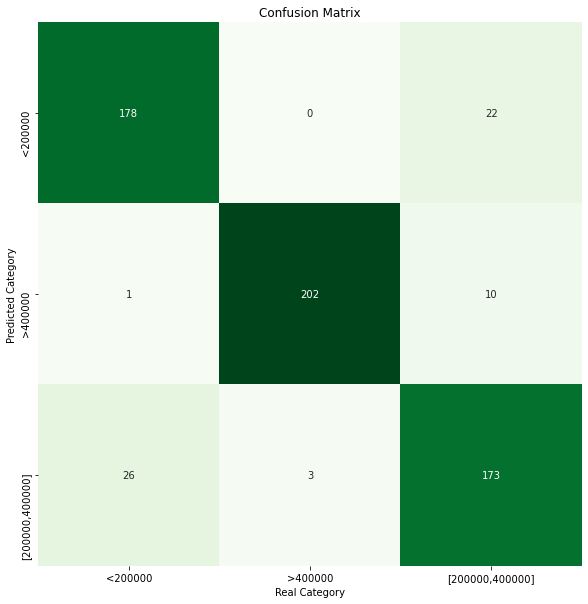

In [57]:
DTC = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=3,
                                min_samples_split=0.25, presort=True, splitter='best')

y_pred_DTC = DTC.fit(X_train, y_train).predict(X_test)
prediction_measures(y_test, y_pred_DTC)
confusionMatrix(y_test, y_pred_DTC)

In [58]:
scoring_metrics(y_test, y_pred_DTC)

Matthews correlation coefficient score (MCC):  0.8489

                  precision    recall  f1-score   support

        <200000       0.89      0.87      0.88       205
        >400000       0.95      0.99      0.97       205
[200000,400000]       0.86      0.84      0.85       205

       accuracy                           0.90       615
      macro avg       0.90      0.90      0.90       615
   weighted avg       0.90      0.90      0.90       615



#### This classifier follows the same trends as the two previous classifiers, classifying fairly well for all classes, but poorer than the previous methods. As for the two previous methods, the class that in the real dataset is over-represented, is the one showin the lowest MCC and F1-scores (although, the `[200000,400000]´ class has similarly lower scores).

## Suming up the three classifiers we have chosen

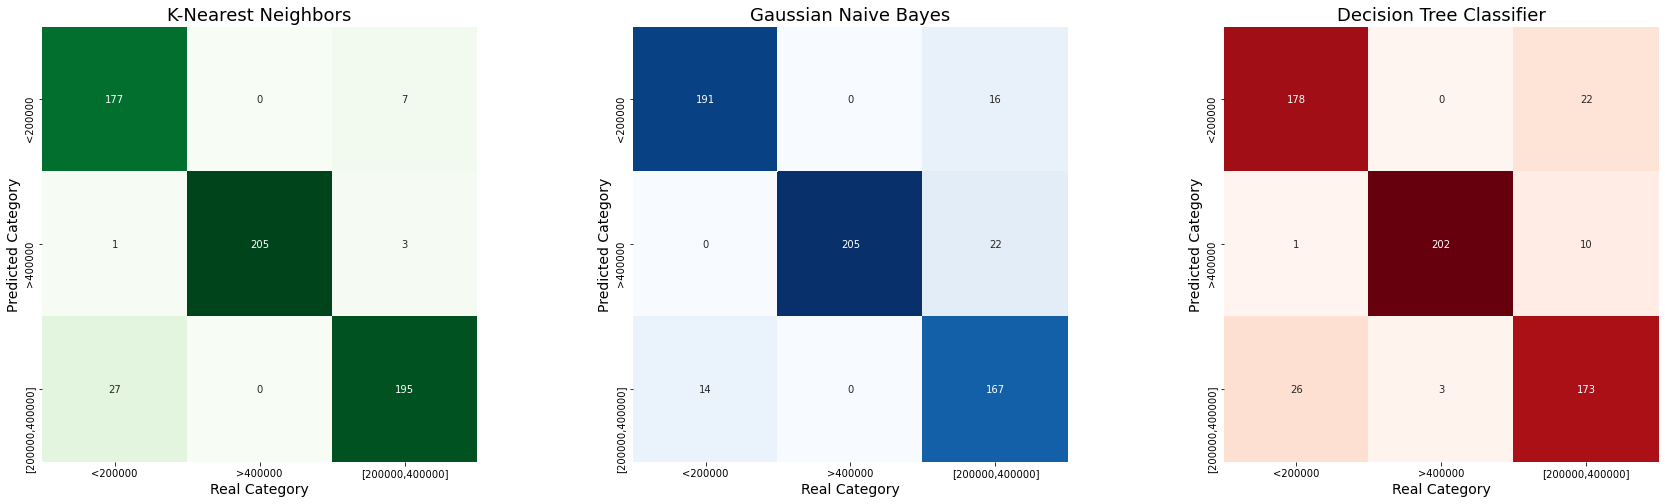

In [184]:
fig = plt.figure(figsize=(30,8))

fig = plt.subplot(1, 3, 1)
cm_test = confusion_matrix(y_test, y_pred_KNN)
sns.heatmap(cm_test.T, cmap='Greens', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('K-Nearest Neighbors', fontsize=18)


fig = plt.subplot(1, 3, 2)
cm_test = confusion_matrix(y_test, y_pred_GNB)
sns.heatmap(cm_test.T, cmap='Blues', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('Gaussian Naive Bayes', fontsize=18)


fig = plt.subplot(1, 3, 3)
cm_test = confusion_matrix(y_test, y_pred_DTC)
sns.heatmap(cm_test.T, cmap='Reds', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('Decision Tree Classifier', fontsize=18)

plt.show()

In [60]:
print('k-Nearest Neighbours scores:')
scoring_metrics(y_test, y_pred_KNN)
print('Gaussian Naive Bayes scores:')
scoring_metrics(y_test, y_pred_GNB)
print('Decision Tree Classifier scores:')
scoring_metrics(y_test, y_pred_DTC)

k-Nearest Neighbours scores:
Matthews correlation coefficient score (MCC):  0.9087

                  precision    recall  f1-score   support

        <200000       0.96      0.86      0.91       205
        >400000       0.98      1.00      0.99       205
[200000,400000]       0.88      0.95      0.91       205

       accuracy                           0.94       615
      macro avg       0.94      0.94      0.94       615
   weighted avg       0.94      0.94      0.94       615

Gaussian Naive Bayes scores:
Matthews correlation coefficient score (MCC):  0.8750

                  precision    recall  f1-score   support

        <200000       0.92      0.93      0.93       205
        >400000       0.90      1.00      0.95       205
[200000,400000]       0.92      0.81      0.87       205

       accuracy                           0.92       615
      macro avg       0.92      0.92      0.91       615
   weighted avg       0.92      0.92      0.91       615

Decision Tree Classifier s

- From the analyses of the results produced by the 3 classifiers, we can see that, overall, they all perform quite well with the provided dataset. If we focus on the MCC score, the lowest score is 0.85, which is quite good.
- No classifier can predict 100% accurately the classes of the objects in the test set.
- The class that is more difficult to predict is the class that was over-represented in the original dataset. Likely, there is more variability in the features of the objects belonging to this class, than in those belonging to objects of the over-sampled classes. Logically, the over-sampled classes will have less variability between samples, making the classification easier. Also, the class that is more difficult to predict, is more likely to have noisy data, including outliers, that might make the classification harder. 
- Overall, the best classifier was K nearest Neighbors, followed by Gaussian Naive Bayes and finally, Decision Tree Classifier.
- We should highlight here that ideally, the models predicted should be tested in a dataset with "real-data". This is, with data that hasn't been over-sampled to compensate for class inbalance. This would give us more faithful results, as our scores might be being overestimated for being tested in "synthetic data".

#### In conclusion, we are happy with our decisions and outcome of our classifiers. There is space for improvement, namely in choosing better features, eliminating features that show multicollinearity between them, eliminating outliers, transform and/or standardize numerical features, increasing the number of parameters to test for each algorithm, etc. 

## 3. Learning Simple Regressors

* Choose **`X` regressors** (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
* Use **grid-search and 10 fold cross-validation** to estimate the best parameters (https://scikit-learn.org/stable/model_selection.html#model-selection). 
* Use the mean absolute error regression loss, or other relevant metrics.

#### Regression is a data mining technique that, similarly to classification, is used for prediction analysis. Regression techniques, are used to predict a range of numeric values (also called continuous values), provided a given dataset. In the present exercise, regression is used to predict the `SalePrice` of a house, based on several features, including quality, location, area, etc.

In this section, and for the sake of academic interest, we will take a slightly different approach with our regression exploration. We will proceed with splitting the regression dataset into training and test sets and use 4 different classifiers, **Linear Regression**, **Decision Tree Regressor**, **K-Nearest Neighbors Regressor** and **Support Vector Machine for Regression**. We will initially estimate the predictive capability of the different algorithms, using default parameters and only after, we will use a `GridSearchCV` coupled with a stratified cross-validation strategy, to be able to visualize the improvement (or lack of) of the regressor. We will use several strategies to evaluate the efficiency of the model, like visualizing the differences between real and predicted values and using metrics like root mean squared error, mean squared error, mean absolute error and the coefficient of determination.

### Let's start by creating our train and test sets.

In [61]:
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(table_X_regression, table_y_regression, test_size=0.25, random_state=42)

print('Number of rows for training:', len(X_train_regression))
print('Number of rows for testing:', len(X_test_regression))
print('\nTrue labels:', len(y_test_regression))

Number of rows for training: 1095
Number of rows for testing: 365

True labels: 365


# Linear Regression

Regression is a data mining (machine learning) technique, used to fit an equation into a given dataset. One of the simplest forms of regression is linear regression. Linear regression determines a formula of a straight line that is then used for finding a linear relationship between target and one or more predictors. 

- Linear Regression, doesn't have hyperparameters to tune, as such we will dive straight into fiting a model into the train set and using it to predict the values of our test set.

In [95]:
# Load the LinearRegression model
LR = LinearRegression()
# Fit the model into our train set
LR.fit(X_train_regression, y_train_regression)

# Make the predictions
lr_preds = LR.predict(X_test_regression)

- In the case in which we have a multivariable linear regression, several variables are compared to the target variable, and a coefficient is calculated for each of these variables. Let's see what are the coefficients chosen by the model for each of the features in our dataset.

In [96]:
coeff_df = pd.DataFrame(LR.coef_, features_names_regression, columns=['Coefficient'])  
coeff_df.sort_values(by=['Coefficient'], ascending=False)

,Coefficient
Neighborhood_NoRidge,45572.138441
Neighborhood_NridgHt,29647.366619
SaleCondition_Partial,16696.456406
OverallQual,13617.100312
MasVnrType_None,13208.323639
GarageCars,12939.983171
KitchenQual,9637.153454
ExterQual,7914.547208
Fireplaces,7814.089344
BsmtExposure,5475.994206


- Looking at the coefficients (that are the slopes of the linear regression equation, between the target variable and a given feature), we can see that there are several features that affect the target variable significantly (either positively or negatively) and a few that have close to no effect (these could have been removed from our dataset).
- Linear regression models are very good at communicating the model and how each feature influences the target variable.

- Let's have an idea of how the real prices compare to the predicted prices.

In [97]:
df = pd.DataFrame({'Actual': y_test_regression.flatten(), 'Predicted': lr_pred.flatten()})
df

,Actual,Predicted
0,154500.0,142429.795756
1,325000.0,341892.734463
2,115000.0,110125.799244
3,159000.0,165218.560120
4,315500.0,290955.768908
...,...,...
360,195000.0,191805.685859
361,120000.0,135855.105604
362,228500.0,230002.668624
363,248000.0,274725.184989


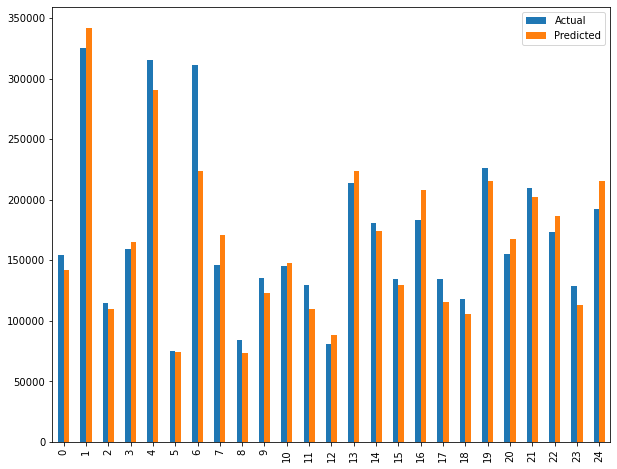

In [98]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')
plt.show()

- Looking at a few of the actual and predicted `SalePrices`, we can actually see that the model seems to have done a pretty good job.

- As we don't have contingency matrixes for regression models, we will use a scatter plot to evaluate the regression models and how good the predictions fit the true values. Using a scatter plot for the actual and predicted values, we have an excellent tool to evaluate the quality of the model. 

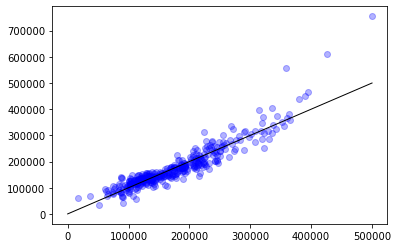

In [99]:
plt.scatter(lr_preds, y_test_regression,  color='blue', alpha=0.3)
plt.plot([0,500000], [0, 500000], linestyle="-", lw=1, color="k")
plt.show()

- The scatter plot shows us that, indeed, the model does a good job at predicting the `SalePrice` values in the test set!

##### Let's use a series of metrics to test our regression models. These include:
1. MAE - Mean Absolute Error is the sum of absolute differences between our target and predicted variables (the lower the better).
2. MSE - Mean Square Error is the sum of squared distances between our target variable and predicted values (the lower the better). Outliers in MSE will contribute much more to the MSE than in MAE.
3. RMSE - Root mean squared eror - Similar to MSE, but the root gives the mean error in the same units as the target variable, making it easier to interpret (the lower the better).
4. R2 or PVE - Proportion of variance explained - how much of the variance of Y is explained by the model (the higher the better).

In [67]:
print("Testing results for the Linear Regression model\n")    
# The mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, lr_pred)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, lr_pred))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, lr_pred))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, lr_pred))

Testing results for the Linear Regression model

Root Mean Squared Error: 31036.281
Mean squared Error: 963250717.59
Mean Absolute Error: 20052.15
Coefficient of determination:  0.862


#### We can observe that the linear model performed remarkably well. The MAE and RMSE are fairly small (20000 for the MAE and 31000 for RMSE, suggesting that outliers are having an impact in the model performance). Also, the R2 score is significantly high, testifying to the competence of the model in making adequate predictions for the `SalePrice` in the test set.
#### From the observation of the scatter plot above, there is an issue that is striking to us. The higher the sale price, the most difficult is for the model to predict a value. This is mostly likely due to the fact that, similarly to the huge class imbalance observed for our classification dataset, in this dataset, very few houses have high prices which make it difficult for the model to learn the features associated with those and predict the target value accurately.

# Decision Tree Regressor

As we mentioned above, Decision trees can also be used for regression. In this case, the decision trees are used with a target variable that takes a continuous value (like, the price of the houses in our dataset).

- As we mentioned before, let's first see how a Decision Tree Regressor with default parameters behaves with our dataset.

In [68]:
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train_regression, y_train_regression)

dtr_preds = dtr.predict(X_test_regression)

- Let's have a look at the actual target variable and what the model predicted.

In [69]:
df = pd.DataFrame({'Actual': y_test_regression.flatten(), 'Predicted': dtr_preds.flatten()})
df

,Actual,Predicted
0,154500.0,139000.0
1,325000.0,359100.0
2,115000.0,110500.0
3,159000.0,163000.0
4,315500.0,285000.0
...,...,...
360,195000.0,190000.0
361,120000.0,101000.0
362,228500.0,267000.0
363,248000.0,236000.0


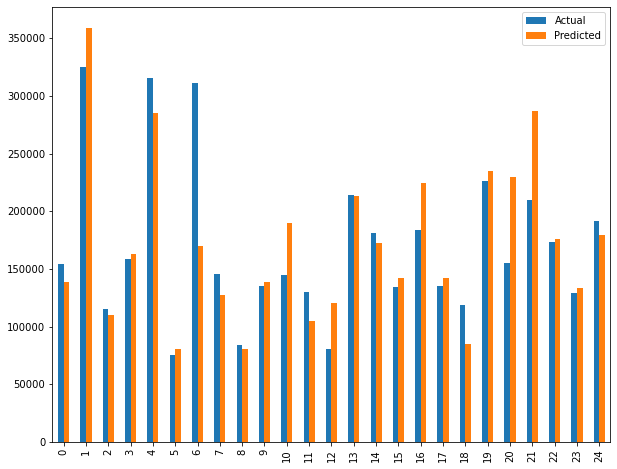

In [70]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')
plt.show()

- At first sight, Decision Trees also seem to do a good job with predicting the target variable.
- Let's have a look at the scatter plot for the dispersion of actual and predicted sale prices.

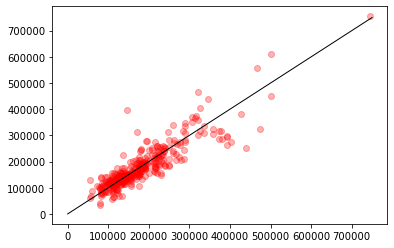

In [71]:
plt.scatter(dtr_preds, y_test_regression,  color='red', alpha=0.3)
plt.plot([0, 750000], [0, 750000], linestyle="-", lw=1, color="k")
plt.show()

- The scatter plot is similar to the one from the linear regression. The model also struggles with more expensive houses and, because decision trees and tree based models are unable to extrapolate to any kind of data they haven't seen before, they suffer more with more expensive houses.
- Moreover, we have the impression that the actual vs predicted prices are not as tight as in the previous scatter plot.

##### Let's use our previous metrics to test our suspicions

In [72]:
print("Testing results for the Decision Tree Regressor model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, dtr_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, dtr_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, dtr_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, dtr_preds))

Testing results for the Decision Tree Regressor model

Root Mean Squared Error: 39302.232
Mean squared Error: 1544665431.35
Mean Absolute Error: 26165.02
Coefficient of determination:  0.780


#### We can observe that, for all the metrics used, the decision tree behaved worst than the linear regressor. All measures of RMSE, MAE, MSE are higher and the R2 score is significantly lower.

## Let's try to fine-tune hyperparameters to get an increase in the prediction score of the model.

#### To discover the best parameters for the regressor, we will use a `GridSearchCV` followed by cross-validation of the models. We will use the R2 score as the metrics to select the best parameters for our model.
- We will test the criterion, min_samples_split and min_samples_leaf parameters.

In [73]:
dtr = DecisionTreeRegressor(random_state=0)

param_grid = [{'criterion': ['mse', 'friedman_mse', 'mae'],
               'min_samples_split': range(1, 10),
               'min_samples_leaf': range(1, 10)}]

gs_dtr = GridSCV(dtr, param_grid, X_train_regression, y_train_regression, r2_score)

Best score: 0.7669013555679598
Best parameters: {'criterion': 'mae', 'min_samples_leaf': 9, 'min_samples_split': 2}
Cross Validation score: 0.744 +/- 0.108


- We can see that the best parameters are criterion: 'mae', min_samples_leaf: 9, and min_samples_split: 2
- We can now take these parameters and use them to fit a model into the training set.
- Let's see how this model behaves on the test set.

In [74]:
dtr_hyper = gs_dtr.best_estimator_
dtr_hyper.fit(X_train_regression, y_train_regression)

dtr_hyper_preds = dtr_hyper.predict(X_test_regression)

In [75]:
print("Testing results for the Decision Tree Regressor model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, dtr_hyper_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, dtr_hyper_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, dtr_hyper_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, dtr_hyper_preds))

Testing results for the Decision Tree Regressor model

Root Mean Squared Error: 35114.897
Mean squared Error: 1233056026.01
Mean Absolute Error: 23036.79
Coefficient of determination:  0.824


#### Using the parametrs obtained from our `GridsearchCV`, we have significative increase in the performance of our regressor model, with generalized decrease of the error metrics and a decent increase in the r2 score.
#### Nevertheless, this algorithm fails to achieve the results of the linear regression model.

# K Nearest Neighbors Regressor

The k-nearest neighbors algorithm (k-NN) can also be used for regression. This algorithm will store all available objects and predict the numerical variable based on a similarity measure (using different distance functions). It acts as a kind of ponderated regression, taking the distance to closest neighbors, to calculate the target variable.

- Let's run the k-NN algorithm with default parameters (assuming a k value of 5), and check how the model predicts the test set.

In [76]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_regression, y_train_regression)
knn_preds = knn.predict(X_test_regression)

- Let's have a look at the actual and predicted target variable for the model.

In [77]:
df = pd.DataFrame({'Actual': y_test_regression.flatten(), 'Predicted': knn_preds.flatten()})
df

,Actual,Predicted
0,154500.0,136800.0
1,325000.0,338752.2
2,115000.0,127350.0
3,159000.0,149000.0
4,315500.0,256656.6
...,...,...
360,195000.0,187280.0
361,120000.0,118580.0
362,228500.0,245900.0
363,248000.0,201100.0


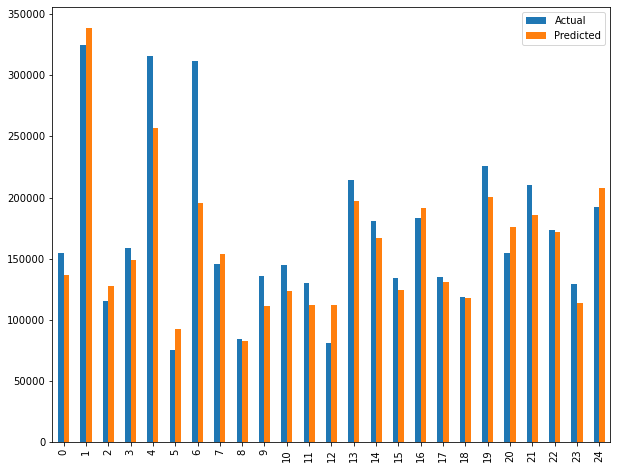

In [78]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')
plt.show()

- The k-NN regressor does a good job at predicting the target variable. 
- Let's have a look at the scatter plot for the actual vs predicted prices.

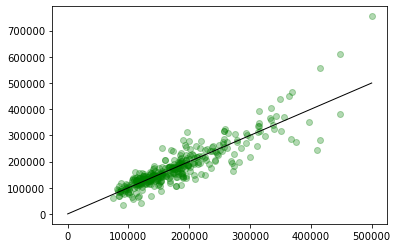

In [79]:
plt.scatter(knn_preds, y_test_regression,  color='green', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.show()

- The algorithm seems to make a good job for lower priced houses, but it's clear that as the true prices increase, the predictive accuracy of the model, lowers. This is similar to what we observe for all the other algorithms and suggests that a solution could be compensating the dataset for the lack of houses in this price range (using `SMOTENC`, for example).
- Let's see the "true colours" of the model.

In [80]:
print("Testing results for the K Nearest Neighbors Regressor model\n")    
# The mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, knn_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, knn_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, knn_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, knn_preds))

Testing results for the K Nearest Neighbors Regressor model

Root Mean Squared Error: 37928.592
Mean squared Error: 1438578100.74
Mean Absolute Error: 24412.39
Coefficient of determination:  0.795


#### The k-NN with default parameters works fairly well and is very comparable to the decision tree regressor at default parameters. Both are lower performants than the linear regression model, and the k-NN regressor is just marginally better than the decision tree regressor.

## Let's try to fine-tune hyperparameters to get an increase in the prediction score of the model.

- We will test the n_neighbors, weights, metric and algorithm parameters.

In [81]:
knn = KNeighborsRegressor()

param_grid = [{'n_neighbors': range(1, 33),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean', 'mahalanobis'],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]

gs_knn = GridSCV(knn, param_grid, X_train_regression, y_train_regression, r2_score)

Best score: 0.7449490726886279
Best parameters: {'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 5, 'weights': 'distance'}
Cross Validation score: 0.725 +/- 0.080


- The best parameters for our data are algorithm: 'brute', metric: 'seuclidean', n_neighbors: 5, weights: 'distance'.
- Let's see use this parameters to create a model and check how it behaves on the test set.

In [82]:
knn_hyper = gs_knn.best_estimator_
knn_hyper.fit(X_train_regression, y_train_regression)

knn_hyper_preds = knn_hyper.predict(X_test_regression)

In [83]:
print("Testing results for the K Nearest Neighbors Regressor model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, knn_hyper_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, knn_hyper_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, knn_hyper_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, knn_hyper_preds))

Testing results for the K Nearest Neighbors Regressor model

Root Mean Squared Error: 32790.822
Mean squared Error: 1075237986.43
Mean Absolute Error: 20227.68
Coefficient of determination:  0.847


#### Using the above parameters, we achieve a much improved score for all the metrics. The R2 score achieves a values of 0.847, close to the 0.862 from the linear regressor. 
#### This model achieves better scores than those of the decision trees.

# Support Vector for Regression

Support-vector machines (SVMs), are techniques used in data mining for classification and regression analysis. They are supervised learning models that learn from training examples assigned to known classes or values, learning a model that is able to assign new objects to a class or value (depending on whether we are using it for classification or regression, respectively). The SVM works essentially by being a discriminative classifier that is defined by a hyperplane that is able to separate objects and categorize them. SVR, albeit not being as popular as SVC, is a very performant tool that can be used for regression. It supports linear and non-linear regression and it works by fitting as many objects as possible, between an error threshold line (epsilon), while limiting marging violations.

- Let's start by running the SVR with default parameters. 
- SVM algorithms use a set of mathematical functions that are known as kernel. The kernel function is of paramount important, as it takes the data and transforms it into a required form. SVRs can have several kernel functions, like linear, polynomial, radial basis function (RBF), etc. The kernel function has a tremendous impact on the ability of the SVR to predict target values.
- The default parameter for SVR is RBF. 

In [84]:
svr = SVR()  
svr = svr.fit(X_train_regression, y_train_regression)
svr_preds = svr.predict(X_test_regression)

- Let's have a look at the actual and predicted target variable for the model.

In [85]:
df = pd.DataFrame({'Actual': y_test_regression.flatten(), 'Predicted': svr_preds.flatten()})
df

,Actual,Predicted
0,154500.0,164988.680035
1,325000.0,165105.515182
2,115000.0,164977.805505
3,159000.0,165022.640642
4,315500.0,165058.301007
...,...,...
360,195000.0,165044.987994
361,120000.0,164977.962302
362,228500.0,165065.157855
363,248000.0,165038.706614


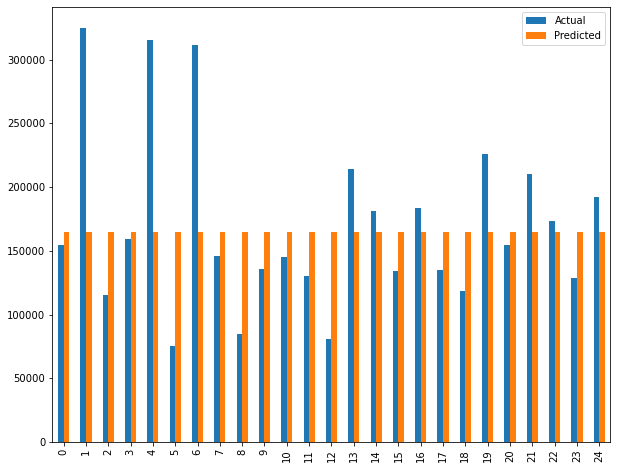

In [86]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')
plt.show()

- Something looks really fishy with our regression. It seems as the SVR model, predicted all the prices similarly. This is likely because the RBF kernel can't define an hyperplane to separate the objects.

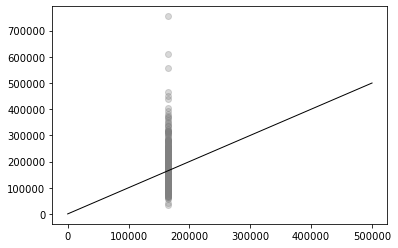

In [87]:
plt.scatter(svr_preds, y_test_regression,  color='gray', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.show()

- Our suspicions were correct. The default SVR model is totally unable to work with our data.

In [88]:
print("Testing results for the Support Vector for Regression model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, svr_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, svr_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, svr_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, svr_preds))

Testing results for the Support Vector for Regression model

Root Mean Squared Error: 84751.607
Mean squared Error: 7182834891.81
Mean Absolute Error: 57189.97
Coefficient of determination: -0.025


#### The SVR clearly fails to properly predict the test set. As such, the SVR will clearly benefit from a thorough hiperparameter tuning.

## Let's try determine the best hyperparameters for SVR to see if we can salvage the algorithm.

- As a GridsearchCV is quite taxing with SVR, we will test a limited set of parameters.
- We will test models with kernel: 'linear' and varying `C` values.
- We will also run GridsearchCV for the kernel: 'rbf' with varying `gamma`, `C` and `epsilon` values.

##### Note: Given how taxing the GridsearchCV was for our computers, we actually made a few prior tests. Namely, we tried all different kernels separately and only the 'linear' kernel is able to produce satisfactory results. We assume this is because of the linear distribution of our data. For that reason, only the 'linear' kernel can efficiently define an hyperplane to separate objects according to their price target. We also slightly changed the `GridSearchcv` and `cross_val_score`, by using a cv=5 and cv=2 respectively.

In [143]:
## NOTE: This takes AGES to run! 
svr = SVR() 

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
param_grid = [{'kernel': ['linear'], 'C': param_range},
              {'kernel': ['rbf'], 'gamma': param_range, 'C': param_range, 'epsilon': param_range2}]

gs_svr = GridSCV(svr, param_grid, X_train_regression, y_train_regression, r2_score)

Best score: 0.7538252621392896
Best parameters: {'C': 1000.0, 'kernel': 'linear'}
Cross Validation score: 0.784 +/- 0.074


- Clearly, the kernel: 'linear' is the kernel to use in our dataset. This is unsurprising, given the linear distribution of the features.
- In addition, an increase in the 'C' value (regularisation parameter that controls how much the model is punished for each misclassified point) also leads to better results.
- Let's see how this model behaves on the test set.

- As we would like to include the 'epsilon' parameter in our gridSearch, we have done it for the 'linear' kernel alone, as running all of the previous GridSearchCV with cross-validation would take too long to run.

In [239]:
## NOTE: This doesn't take AGES to run... but it takes ages to run! 
svr = SVR() 

param_range = [1.0, 10.0, 100.0, 1000.0]
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0]
param_grid = [{'kernel': ['linear'], 'C': param_range, 'epsilon': param_range2}]

gs_svr2 = GridSCV(svr, param_grid, X_train_regression, y_train_regression, r2_score)

Best score: 0.7543956744696642
Best parameters: {'C': 1000.0, 'epsilon': 1.0, 'kernel': 'linear'}
Cross Validation score: 0.783 +/- 0.074


- We see a very marginal increase in the best score of the grid search, with a lower score in the cross-validation. For that reason, we decided to keep the parameters obtained from our first hyperparameter tuning with grid search.

In [89]:
svr_hyper = SVR(kernel='linear', C=1000)
#svr_hyper = gs_svr.best_estimator_
svr_hyper.fit(X_train_regression, y_train_regression)

svr_hyper_preds = svr_hyper.predict(X_test_regression)

- Let's have a look at the actual and predicted target variable for the model.

In [90]:
df = pd.DataFrame({'Actual': y_test_regression.flatten(), 'Predicted': svr_hyper_preds.flatten()})
df

,Actual,Predicted
0,154500.0,146448.042971
1,325000.0,320792.207484
2,115000.0,103137.784022
3,159000.0,156456.169741
4,315500.0,282558.105387
...,...,...
360,195000.0,196953.508982
361,120000.0,128005.968409
362,228500.0,244737.313471
363,248000.0,236977.920512


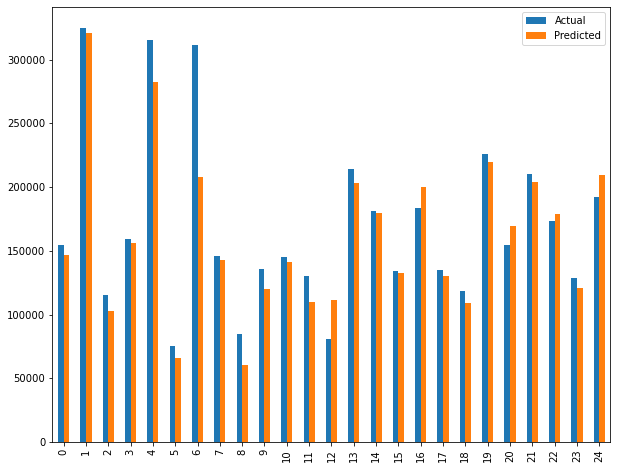

In [91]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')
plt.show()

- Clearly the algorithm seems to be making very competent predictions with our estimated parameters.
- Let's have a look at the scatter plot for the actual vs predicted prices.

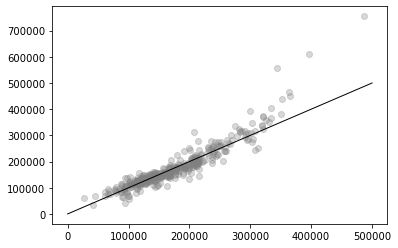

In [92]:
plt.scatter(svr_hyper_preds, y_test_regression,  color='gray', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.show()

- The reborn SVR seems to be making an excellent job at predicting the sale price of the houses in the test set. The scatter plot shows a tight distribution of actual vs predicted values and seems to be comparable to the scatter plot we obtained for the Linear Regression model. 
- As with all other algorithms, SVR doesn't deal well with higher priced houses.
- Let's look under the hood and see how the model is really performing.

In [93]:
print("Testing results for the Support Vector for Regression model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, svr_hyper_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, svr_hyper_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, svr_hyper_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, svr_hyper_preds))

Testing results for the Support Vector for Regression model

Root Mean Squared Error: 31684.344
Mean squared Error: 1003897677.57
Mean Absolute Error: 18894.00
Coefficient of determination:  0.857


#### The renewed SVR model performed remarkably well and is comparable to the linear regression model. The MAE score is lower for the SVR, but the RMSE and MSE are higher. This is actually unexpected, as the SVR algorithm is supposed to deal with outliers better. Finally, the R2 score of the SVR is just a few points shy from that of the linear regression model. 
#### As we mentioned, with all the regressors, the SVR struggles with predicting the sale price for houses with high prices. This confirms that only a new round of feature engineering will be able to compensate for this.

## Suming up the three classifiers we have chosen

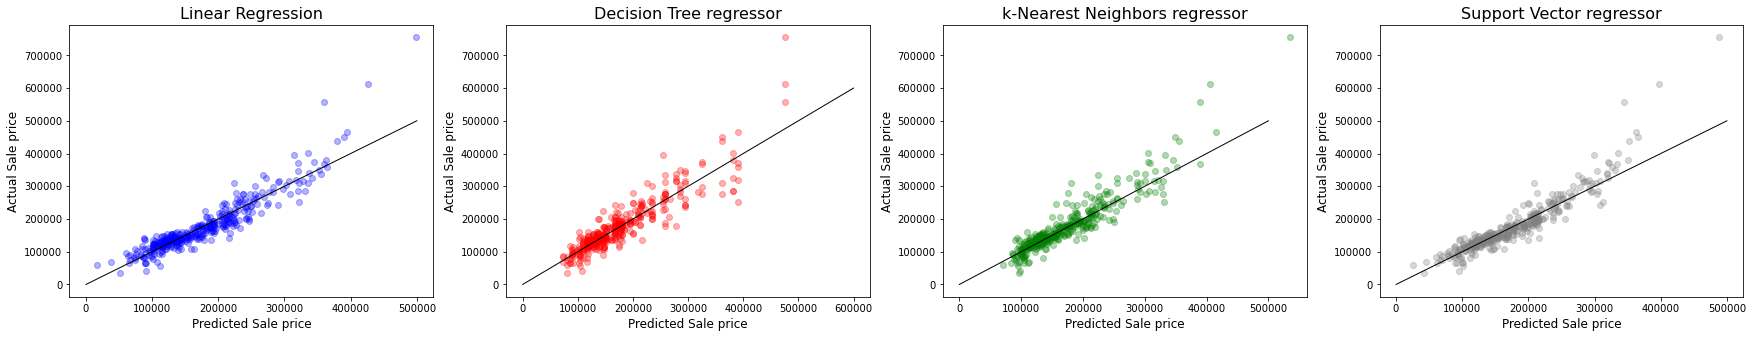

In [100]:
fig = plt.figure(figsize=(30,5))

fig = plt.subplot(1, 4, 1)
plt.scatter(lr_preds, y_test_regression,  color='blue', alpha=0.3)
plt.plot([0,500000], [0, 500000], linestyle="-", lw=1, color="k")
plt.title("Linear Regression", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(1, 4, 2)
plt.scatter(dtr_hyper_preds, y_test_regression,  color='red', alpha=0.3)
plt.plot([0, 600000], [0, 600000], linestyle="-", lw=1, color="k")
plt.title("Decision Tree regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(1, 4, 3)
plt.scatter(knn_hyper_preds, y_test_regression,  color='green', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.title("k-Nearest Neighbors regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(1, 4, 4)
plt.scatter(svr_hyper_preds, y_test_regression,  color='gray', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.title("Support Vector regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

plt.show()

In [101]:
score_data = {'Linear Regression': [np.sqrt(mean_squared_error(y_test_regression, lr_pred)), mean_squared_error(y_test_regression, lr_pred), mean_absolute_error(y_test_regression, lr_pred), r2_score(y_test_regression, lr_pred)],
        'Decision Trees': [np.sqrt(mean_squared_error(y_test_regression, dtr_hyper_preds)), mean_squared_error(y_test_regression, dtr_hyper_preds), mean_absolute_error(y_test_regression, dtr_hyper_preds), r2_score(y_test_regression, dtr_hyper_preds)],
        'K Nearest Neighbors': [np.sqrt(mean_squared_error(y_test_regression, knn_hyper_preds)), mean_squared_error(y_test_regression, knn_hyper_preds), mean_absolute_error(y_test_regression, knn_hyper_preds), r2_score(y_test_regression, knn_hyper_preds)],
        'Support Vector Regressor': [np.sqrt(mean_squared_error(y_test_regression, svr_hyper_preds)), mean_squared_error(y_test_regression, svr_hyper_preds), mean_absolute_error(y_test_regression, svr_hyper_preds), r2_score(y_test_regression, svr_hyper_preds)]}

df_scores = pd.DataFrame(score_data)
df_scores = df_scores.rename(index={0: 'RMSE', 1: 'MSE', 2: 'MAE', 3: 'R2'})
pd.set_option('display.float_format', '{:.3f}'.format)

df_scores

,Linear Regression,Decision Trees,K Nearest Neighbors,Support Vector Regressor
RMSE,31036.281,35114.897,32790.822,31684.344
MSE,963250717.588,1233056026.010,1075237986.432,1003897677.566
MAE,20052.154,23036.790,20227.685,18893.997
R2,0.862,0.824,0.847,0.857


- We choose to test four different regressors for this exercise. A simple Linear Regression, and three other supervised machine learning techniques that can be parametrized, Decision Trees, K-Nearest Neighbors and Support Vector Machines. 
- As for the classification exercise, all the algorithms performed fairly well, with R2 scores above 0.82, and mean absolute errors between 18890 and 23000 USD. Without being perfect regressors, they perform quite well. 
- As we mentioned previously, all the regressors perform better for classes priced between 100000 and 35000 USD. This correponds to the prices of the majority of the houses sold. That's in essence, the reason the regressors perform worst for more expensive houses. Given that there are very few houses at these higher price ranges, the models can't learn well how to predict the values for these. 
- From all the different regressors, Decision Trees perform the worst, followed by K-Nearest Neighbors. Nevertheless, after tuning hyperameters, the regression scores are very decent.
- The best regressors are the Linear regression and suport vector machine algorithms. And it is very hard to determine a winner. Whereas the linear regression model seems to perform better overal, the SVR does an extraordinarily good job predicting houses at lower prices. In fact, the MAE of the SVR is lower than that of the linear regression models. Also, the scatter plot seems much more accurate for the lower priced houses. Nevertheless, globally, the linear regression model takes the crown by photo-finish! SVR should be able to handle outliers better than LR, so it is surprising to see that the SVR shows higher RMSE and MSE scores. We suspect that parametrization of the epsilon paramenter could have further improved the regression efficiency of the SVR. Unfortunately, due to the extreme computing taxing of our computers, we couldn't finish this gridsearchcv.

#### In conclusion, we find these results to be extremely encouring and exciting. The regressors perform strikingly well and show promise to become much better models. As with the classification problems we have encountered, there are certain steps that could have been taken to further improve our results. As we observed with the coefficients provided by the LR algorithm, we could fine tune the set of features selected to pick better features to predict the target value. Furthermore, there are some issues with the data that could be corrected. These include a skewed distribution of `SalePrice` values, lack of representation of higher priced houses, existance of outliers and multicollinearity between features. Solutions could include standardization and transformation of numerical variables, using `SMOTENC` to compensante for the inbalance in higher priced houses, elimination of outliers and multicollinear features that can be introducing noise in the models.

## 4. Ensemble Learning

#### Ensemble learning is a data mining technique, in which several models, such as classifiers or regressors (aka, "the experts") are combined to provide a more capable solution than any of the individual models could predict. In practical terms, ensemble techniques are used to improve the classification or regression efficiency of a set of models as well as reducing the errors they might commit in their predictions. This is achieved as each of the individual models (our "experts") votes to predict the class (or value) of a given object. The ensemble collects all the votes and, based on these votes, returns its own (informed) predictions. 

In this section, we will test different Ensemble Methods to try to improve our previous classification and regression results. We will use 3 different types of ensemble methods, Voting, XGBoost and Random Forests. All of these will be applied in our classification and regression datasets. For the XGBoost and Random Forests algorithms, a slighlty modified grid search will be run, `RandomizedSearchCV`, to reduce the computing power required to determine best hyperparameters. The `RandomizedSearchCV` is not as powerful as our previous methods, as it randomly selects a combination of parameters to determine the best ones. This means that it might actually fail to find the best parameters for our dataset. Keeping this handicap in mind, for the sake of time and computing power required, this was a necessary sacrifice we had to take. 

We will compare all of our results with the results obtained previously, from our individual classification and regression models.

### Voting Classifier/Regressor

* Use a voting classifier (http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)/regressor(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) to combine the best results of the `X` classifiers/regressors from previous sections. 

# Voting Classifier

Voting classifier is a combined model that uses multiple different models (in this case, the models K-Nearest Neighbors, Decision Tree and Gaussian Naive Bayes classifiers that we created previously) as sub-estimators into a single model, which is, in theory, a better classifier than any of the individual models.

In this case, we hope that the Voting Classifier using the the classifier models we have previously calculated, can improve the ability to classify the data in the test set.

In [102]:
vot_clas = VotingClassifier(estimators=[('knn', KNN), ('gnb', GNB), ('dtc', DTC)], voting='hard')

scoring = make_scorer(matthews_corrcoef)

for clf, label in zip([KNN, GNB, DTC, vot_clas], ['K-Nearest Neighbors', 'Decision Trees', 'Gaussian naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_test, y_test, cv=10, scoring=scoring)
    print("Matthews correlation coefficient: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Matthews correlation coefficient: 0.84 (+/- 0.06) [K-Nearest Neighbors]
Matthews correlation coefficient: 0.84 (+/- 0.07) [Decision Trees]
Matthews correlation coefficient: 0.89 (+/- 0.05) [Gaussian naive Bayes]
Matthews correlation coefficient: 0.92 (+/- 0.04) [Ensemble]


- Comparing the Matthews Correlation coefficient values for the different classifiers with those of the Voting classifier, we can see that, in fact, combined voting of our set of classifiers allowed us to obtain a MCC of 0.92 which is really good and better than any of the individual classifiers. Now let's check the confusion matrix of the prediction made by this ensemble classifier.

Mislabeled elements: 30
Precision: 0.951
Recall: 0.951


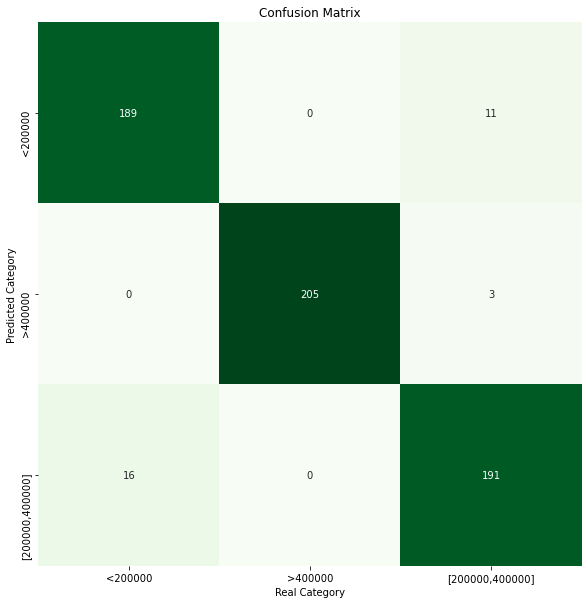

In [108]:
vot_clas.fit(X_train, y_train)
vot_clas_preds = vot_clas.predict(X_test)
prediction_measures(y_test, vot_clas_preds)
confusionMatrix(y_test, vot_clas_preds)

In [109]:
scoring_metrics(y_test, vot_clas_preds)

Matthews correlation coefficient score (MCC):  0.9269

                  precision    recall  f1-score   support

        <200000       0.94      0.92      0.93       205
        >400000       0.99      1.00      0.99       205
[200000,400000]       0.92      0.93      0.93       205

       accuracy                           0.95       615
      macro avg       0.95      0.95      0.95       615
   weighted avg       0.95      0.95      0.95       615



#### Considering the 30 mislabeled elements we can see that this classifier can classify better than the individual classifiers. The closest individual classifier, K-Nearest_Neighbors, classifies with 38 mislabeled elements.
#### Considering the low number of mislabed elements and the 0.92 MCC of the voting classifier, as well as the precision of 0.949 makes this model the best model yet for classifying our data. Furthermore, we should try other ensemble models to see if we can lower the number of mislabeled elements and increase the MCC and precision values.

# Voting Regressor

Just like the voting classifier, the voting regressor allows the usage of an ensemble of multiple different models (in this case, K-Nearest Neighbors, Decision Trees, Linear Regression and Support Vector Machines) as sub-estimators into a single model, which is, in theory, a better regressor than any the individual models.

In [105]:
vot_regression = VotingRegressor(estimators=[('lr', LR), ('dtr', dtr_hyper), ('knn', knn_hyper), ('svr', svr_hyper)])

scoring = make_scorer(r2_score)

for clf, label in zip([LR, dtr_hyper, knn_hyper, svr_hyper, vot_regression], ['Linear Regression', 'Decision Trees', 'K-Nearest Neighbors', 'Support Vector Regressor', 'Ensemble']):
    scores = cross_val_score(clf, X_test_regression, y_test_regression, scoring=scoring)
    print("Coefficient of determination: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Coefficient of determination: 0.85 (+/- 0.05) [Linear Regression]
Coefficient of determination: 0.72 (+/- 0.04) [Decision Trees]
Coefficient of determination: 0.76 (+/- 0.09) [K-Nearest Neighbors]
Coefficient of determination: 0.85 (+/- 0.05) [Support Vector Regressor]
Coefficient of determination: 0.85 (+/- 0.06) [Ensemble]


- Considering the coefficient of determination, we can see that using the voting regressor doesn't improve much further the regression efficiency of our previous models. The R2 score obtained from the voting regressor is similar to those of the LR and SVR models.
- Let's see the scatter plot for the ensemble regression.

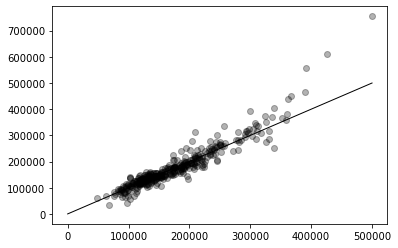

In [114]:
vot_regression.fit(X_train_regression, y_train_regression)
vot_regression_preds = vot_regression.predict(X_test_regression)

plt.scatter(vot_regression_preds, y_test_regression,  color='black', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.show()

- As with previous models, the voting regressor does a pretty good job with attributing a price to the houses in the test set. The scatter plot seems really compact, indicating that the prices estimated are close to the real values.
- As with all models, the voting regressor is weaker for more expensive houses, where no model has been properly trained.
- Let's take a look at the performance metrics of the voting regressor.

In [115]:
print("Testing results for the Voting Regressor model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, vot_regression_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, vot_regression_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, vot_regression_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, vot_regression_preds))

Testing results for the Voting Regressor model

Root Mean Squared Error: 29102.906
Mean squared Error: 846979127.75
Mean Absolute Error: 17107.71
Coefficient of determination:  0.879


#### Considering the compactness of the scatter plot around the linear diagonal, we can see that the voting regressor is a good regressor for our data. We can see that it betters (even if marginally) all the individual models, independently of the metric considered. In fact, the voting regressor used the expertise of each model and was able to also reduce the number of errors in predicting a sale price. 

# XGBoost 
* Use [XGBoost](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn).

XGBoost stands for eXtreme Gradient Boosting. It's a machine learning algorithm, based on decision trees, that uses a gradient boosting framework. Boosting algorithms basically work with individual trees voting for each of the objects of the training set. After one classifier has voted, the next classifier will use that information to "boost" its vote. Gradient boosting is a special case of boosting, where errors are minimized by gradient descent algorithms. XGBoost is a popular Gradient Boosting technique that optimizes the results, using less computing power.

## XGBoost for Classification
- XGBoost can be used for both classification and regression purposes. Let's get our hands in it.

As running our standard `GridsearchCV` would be very taxing to our computers, we decided to use a slightly less demanding `RandomizedSearchCV`.
- We tested the parameters 'colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'n_estimators' and 'subsample'. 

In [156]:
xgb_classifier_model = xgb.XGBClassifier()

params = {"colsample_bytree": uniform(0.7, 0.3), "gamma": uniform(0, 0.5), "learning_rate": uniform(0.03, 0.3), "max_depth": randint(2, 6), "n_estimators": randint(100, 150), "subsample": uniform(0.6, 0.4)}

search = RandomizedSearchCV(xgb_classifier_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.7min finished


Model with rank: 1
Mean validation score: 0.965 (std: 0.007)
Parameters: {'colsample_bytree': 0.8883701168472723, 'gamma': 0.040879515974435954, 'learning_rate': 0.29207358723203314, 'max_depth': 4, 'n_estimators': 147, 'subsample': 0.6244311839419455}



- The list of best parameters for the XGBoost model are `colsample_bytree` = 0.8883701168472723, `gamma` = 0.040879515974435954, `learning_rate` = 0.29207358723203314, `max_depth` = 4, `n_estimators`= 147, `subsample` = 0.6244311839419455.
- Let's run our XGBoost algorithm and see how it performs in classifying our test set.

Mislabeled elements: 15
Precision: 0.976
Recall: 0.976


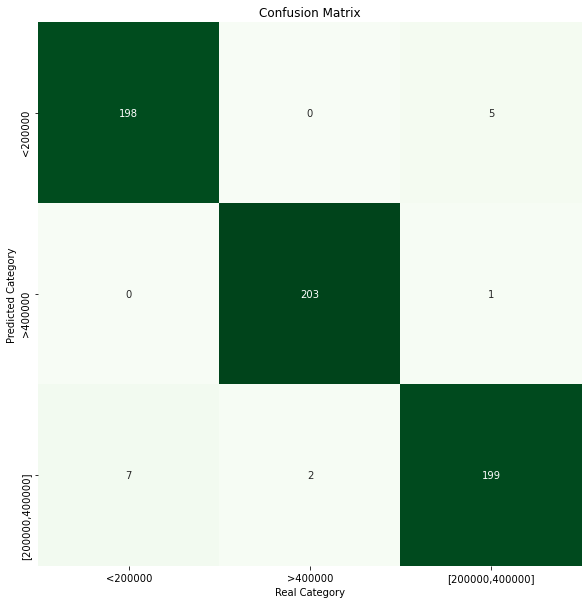

In [122]:
xgb_class = xgb.XGBClassifier(colsample_bytree = 0.8883701168472723, gamma = 0.040879515974435954, learning_rate = 0.29207358723203314, max_depth = 4, n_estimators= 147, subsample = 0.6244311839419455)
xgb_class.fit(X_train, y_train)

xgb_class_preds = xgb_class.predict(X_test)

prediction_measures(y_test, xgb_class_preds)
confusionMatrix(y_test, xgb_class_preds)

In [123]:
scoring_metrics(y_test, xgb_class_preds)

Matthews correlation coefficient score (MCC):  0.9634

                  precision    recall  f1-score   support

        <200000       0.98      0.97      0.97       205
        >400000       1.00      0.99      0.99       205
[200000,400000]       0.96      0.97      0.96       205

       accuracy                           0.98       615
      macro avg       0.98      0.98      0.98       615
   weighted avg       0.98      0.98      0.98       615



#### The XGBoost classifier manages to increase scores for all metrics, including the MCC. This is translated in the reduction of misslabelled elements to 15, the lowest number we have achieved with all of the classifiers we have used. Unsurprisingly, this model is the best model yet, showing that this ensemble algorithm might be the best classification solution for our data.

## XGBoost for Regression
- We next will try to use XGBoost for performing regression in our dataset.

As for the XGBoost for classification, we have used `RandomizedSearchCV` to determine the best parameters for the algorithm.
- We tested the same parameters as before: 'colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'n_estimators' and 'subsample'. 

In [157]:
xgb_regressor_model = xgb.XGBRegressor()

params = {"colsample_bytree": uniform(0.7, 0.3), "gamma": uniform(0, 0.5), "learning_rate": uniform(0.03, 0.3), "max_depth": randint(2, 6), "n_estimators": randint(100, 150), "subsample": uniform(0.6, 0.4)}

search = RandomizedSearchCV(xgb_regressor_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
search.fit(X_test_regression, y_test_regression)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.1s finished


Model with rank: 1
Mean validation score: 0.858 (std: 0.038)
Parameters: {'colsample_bytree': 0.7498850106268238, 'gamma': 0.3690168082131852, 'learning_rate': 0.054839600377537934, 'max_depth': 5, 'n_estimators': 125, 'subsample': 0.6272998821416366}



- The list of best parameters for the XGBoost regression model are `colsample_bytree`= 0.7498850106268238, `gamma`= 0.3690168082131852, `learning_rate`= 0.054839600377537934, `max_depth`= 5, `n_estimators`= 125, `subsample`= 0.6272998821416366.
- Let's see how our XGBoost regressor performs with these parameters.

In [129]:
xgb_regression = xgb.XGBRegressor(colsample_bytree=0.7498850106268238, gamma=0.3690168082131852, learning_rate=0.054839600377537934, max_depth=5, n_estimators=125, subsample=0.6272998821416366)
xgb_regression.fit(X_train_regression, y_train_regression)

xgb_regression_preds = xgb_regression.predict(X_test_regression)

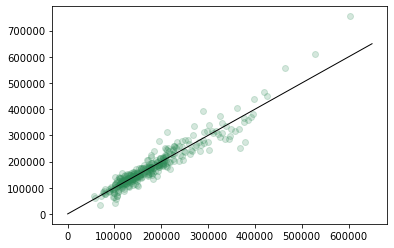

In [161]:
plt.scatter(xgb_regression_preds, y_test_regression,  color='seagreen', alpha=0.2)
plt.plot([50,650000], [50, 650000], linestyle="-", lw=1, color="k")
plt.show()

- Looking at the scatter plot, we have the feeling that XGBoost performs exceptionally well. Even if the prediction of higher priced houses is, as usual, more inconsistent, the difference between actual and predicted values seems to be lower (the objects are, globally, closely located to the diagonal).
- Let's have a look at the metrics of this Ensemble method for regression.

In [136]:
print("Testing results for the XGBoost regressor model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, xgb_regression_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, xgb_regression_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, xgb_regression_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, xgb_regression_preds))

Testing results for the XGBoost regressor model

Root Mean Squared Error: 25147.928
Mean squared Error: 632418280.77
Mean Absolute Error: 16891.87
Coefficient of determination:  0.910


#### We are at a loss of words! The XGBoost regressor performs remarkably well and, with so little high priced objects to train, using its gradient boosting approach, produces what we find to be completely extraordinary results. Even if the prices of the most expensive houses are still further from the actual price, this algorithm manages to reduce all error metrics, increasing the R2 score to 0.910. If we had more time to further process the dataset, we believe we would have achieved an even better regression efficiency. 

# Random Forests

* Use [Random Forests](http://scikit-learn.org/stable/modules/ensemble.html#random-forests).

A random forest model is based on the combination of multiple decision trees into a single model. It is considered a bagging model, in which many very simple classifiers are grouped together to perform a better job than what a single sophisticated classifier would do. Thus, the decision trees individualy may not be accurate, but when combined together in a model, they allow very good predictions. Each individual decision tree gives us a class prediction. The class that gets more votes (the mode class) is then assumed as our model's prediction. The random forest uses a random subspace method and bagging to prevent overfitting. Furthermore, it has implemented an automated feature selection. Because of these characteristics, Random Forest is known to be a very efficient Machine Learning Algorithm.

Random forest algorithms allow both classification and regression:

 - `RandomForestClassifier` and `RandomForestRegressor` are estimators that fits a great number of decision trees classifiers into a model. Each decision tree is applied to a sub-sample of the dataset. It then uses averaging to increase the prediction accuracy. 

## Random Forest Classifier
- We next will run Random Forest Classifier for performing classification in our dataset.

We initially tried to use `GridSearchCV` to determine the best parameters for the algorithm, but this was really taxing for our computers. We were thus forced to use `RandomizedSearchCV`, to try to find a good set of parameters for the model.
- We tested the following parameters: 'criterion', 'n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf' and 'bootstrap'.
- We leave our initial `GridSearchCV` code that we were unable to run.

In [ ]:
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train,y_train)

param_grid = dict(n_estimators=[10, 25],max_depth=[None, 5, 10, 20],min_samples_leaf=[1,2,4],
                 criterion=['gini','entropy'], bootstrap = [True, False],warm_start = [True, False],
                 random_state=[0,1,2])

GridSCV(clf_RF, param_grid, X_train, y_train, matthews_corrcoef)

In [164]:
# Criterion to use
criterion = ['gini','entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RF_classifier = RandomForestClassifier()

search = RandomizedSearchCV(RF_classifier, param_distributions = random_grid, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 3)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 36.1min finished


Model with rank: 1
Mean validation score: 0.969 (std: 0.007)
Parameters: {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.968 (std: 0.006)
Parameters: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.968 (std: 0.007)
Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.968 (std: 0.008)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.968 (std: 0.007)
Parameters: {'n_es

- The list of best parameters for the RFR regression model are `n_estimators`= 1600, `min_samples_split`= 5, `min_samples_leaf`= 2, `max_features`= `sqrt`, `max_depth`= 30, `criterion`= 'entropy', `bootstrap`= False.
- Let's run the RFC model and see how it performs in classifying our test set.

Mislabeled elements: 15
Precision: 0.976
Recall: 0.976


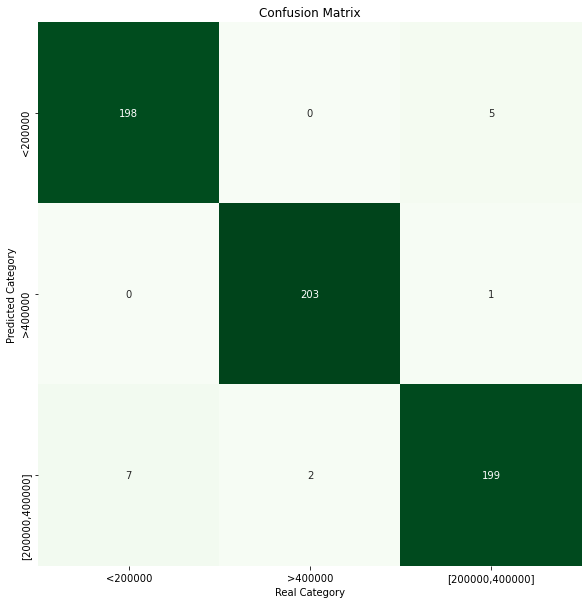

In [165]:
RFC = RandomForestClassifier(n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', max_depth=30, criterion='entropy', bootstrap=False)
RFC.fit(X_train, y_train)
                            
RFC_preds = xgb_class.predict(X_test)

prediction_measures(y_test, RFC_preds)

confusionMatrix(y_test, RFC_preds)

In [166]:
scoring_metrics(y_test, RFC_preds)

Matthews correlation coefficient score (MCC):  0.9634

                  precision    recall  f1-score   support

        <200000       0.98      0.97      0.97       205
        >400000       1.00      0.99      0.99       205
[200000,400000]       0.96      0.97      0.96       205

       accuracy                           0.98       615
      macro avg       0.98      0.98      0.98       615
   weighted avg       0.98      0.98      0.98       615



#### Classification using the Random Forest Classifier is one of the best, togehter with the XGBoost classifier model. In fact, they give exactly the same metrics. Similarly to XGBoost, we were able to reduce the number of mislabeled objects to only 15. 
#### When compared with the results of K-Nearest Neighbors, the simple classification method with the best results, obtaining 38 mislabeled elements, we observe that the number of mislabeled elements is much lower. This clearly testifies to the strenght of using Ensemble methods for classification purposes.
#### Thus, for the "classification competition", we have two winners: XGBoost and Random Forest Classifier.

## Random Forest Regressor
- We will next run Random Forest Regressor for performing regression in our dataset.

- With our `RandomizedSearchCV`, we tested the same parameters as before: 'criterion', 'n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf' and 'bootstrap'.
- We leave our initial `GridSearchCV` code that we were unable to run.

In [ ]:
# This was the GridSearchCV with cross-validation that we tried to run to estimate the hyperparameters for our RFR, but due to the timing it was taking to run,
# we had to abandon this strategy for an alternative one.
reg_RF = RandomForestRegressor()

param_grid = dict(n_estimators=[10, 25],max_depth=[None,1],min_samples_leaf=[1,2],
                 criterion=['mse','mae'], bootstrap = [True, False],warm_start = [True, False],
                 random_state=[0,1])

GridSCV(reg_RF, param_grid, X_train_regression, y_train_regression, r2_score)

In [153]:
# Criterion to use
criterion = ['mse', 'mae']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RF_regressor = RandomForestRegressor()

search = RandomizedSearchCV(RF_regressor, param_distributions = random_grid, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
search.fit(X_test_regression, y_test_regression)

report_best_scores(search.cv_results_, 3)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 29.3min finished


Model with rank: 1
Mean validation score: 0.862 (std: 0.049)
Parameters: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'mae', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.862 (std: 0.051)
Parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'mse', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.862 (std: 0.052)
Parameters: {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'criterion': 'mae', 'bootstrap': False}



- The list of best parameters for the RFR regression model are `n_estimators`= 1600, `min_samples_split`= 2, `min_samples_leaf`= 1, `max_features`= `sqrt`, `max_depth`= 100, `criterion`= 'mae', `bootstrap`= False.
- Let's see how our XGBoost regressor performs with these parameters.

In [159]:
RFR = RandomForestRegressor(n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=100, criterion='mae', bootstrap=False)
RFR.fit(X_train_regression, y_train_regression)

RFR_preds = RFR.predict(X_test_regression)

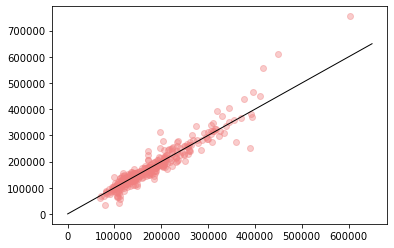

In [160]:
plt.scatter(RFR_preds, y_test_regression,  color='lightcoral', alpha=0.4)
plt.plot([50,650000], [50,650000], linestyle="-", lw=1, color="k")
plt.show()

- Similarly to the XGBoost algorithm, the Random Forest Regressor seems to perform very well. As with the previous model, this ensemble technique gives much accurate predictions of the target price, all over the price ranges (again falling in performance towards the higher values).
- We managed to have a good dispersion of the values around the linear diagonal which indicates a great proximity of the predicted values with the true values of the house prices.
- Let's have a look at the metrics of the Random Forest Regressor model we just created.

In [163]:
print("Testing results for the Random Forest Regressor model\n")    
# The root of the mean squared error
print("Root Mean Squared Error: %6.3f" % np.sqrt(mean_squared_error(y_test_regression, RFR_preds)))
# The mean squared error
print('Mean squared Error: %.2f' % mean_squared_error(y_test_regression, RFR_preds))
# The mean absolute error
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test_regression, RFR_preds))  
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %6.3f" % r2_score(y_test_regression, RFR_preds))

Testing results for the Random Forest Regressor model

Root Mean Squared Error: 26267.633
Mean squared Error: 689988530.79
Mean Absolute Error: 16206.80
Coefficient of determination:  0.902


#### Similarly to the XGBoost, the Random Forest Regressor gets an A grade in its predictive accuracy. Whereas the RMSE and MSE are higher than with XGBoost, suggesting that the RFR deals slighlty worst with outliers, the MAE is actually lower for this model. The R2 score is above 0.902, slightly lower than that of the XGBoost, but a close 2nd to our list of regressor champions.

# Conclusion

## Pre-processing

- Regarding the pre-processing of our data, one of the aspects that we consider to be weakest for the development of our regression and classification models is the balance of the data. We balanced the data before splitting it into train and test sets. As a result, a big bias in relation to the predictions of our models may be happening. We tried to rectify this problem, but given our time constraints, we were unable to do so. We leave this critical note regarding this aspect of the work.

- Dealing with missing data was also a complex task. We were able to remove features with large percentage of missing data. We were also able, using the One Hot Encoder, to convert nominal features into numeric features. We then determined using correlation matrixes, Random Forests and univariate analysis which features would be most relevant to explain the `SalePrice` variable. We initially considered working only with the 40 most important variables. Later we observed that considering the relative importance of each feature, many of these were not as significant as we initially thought. It would probably have been interesting to use a smaller number of variables. Once again, time constraints prevented us from exploring this component of preprocessing.

## The "Classification competition"

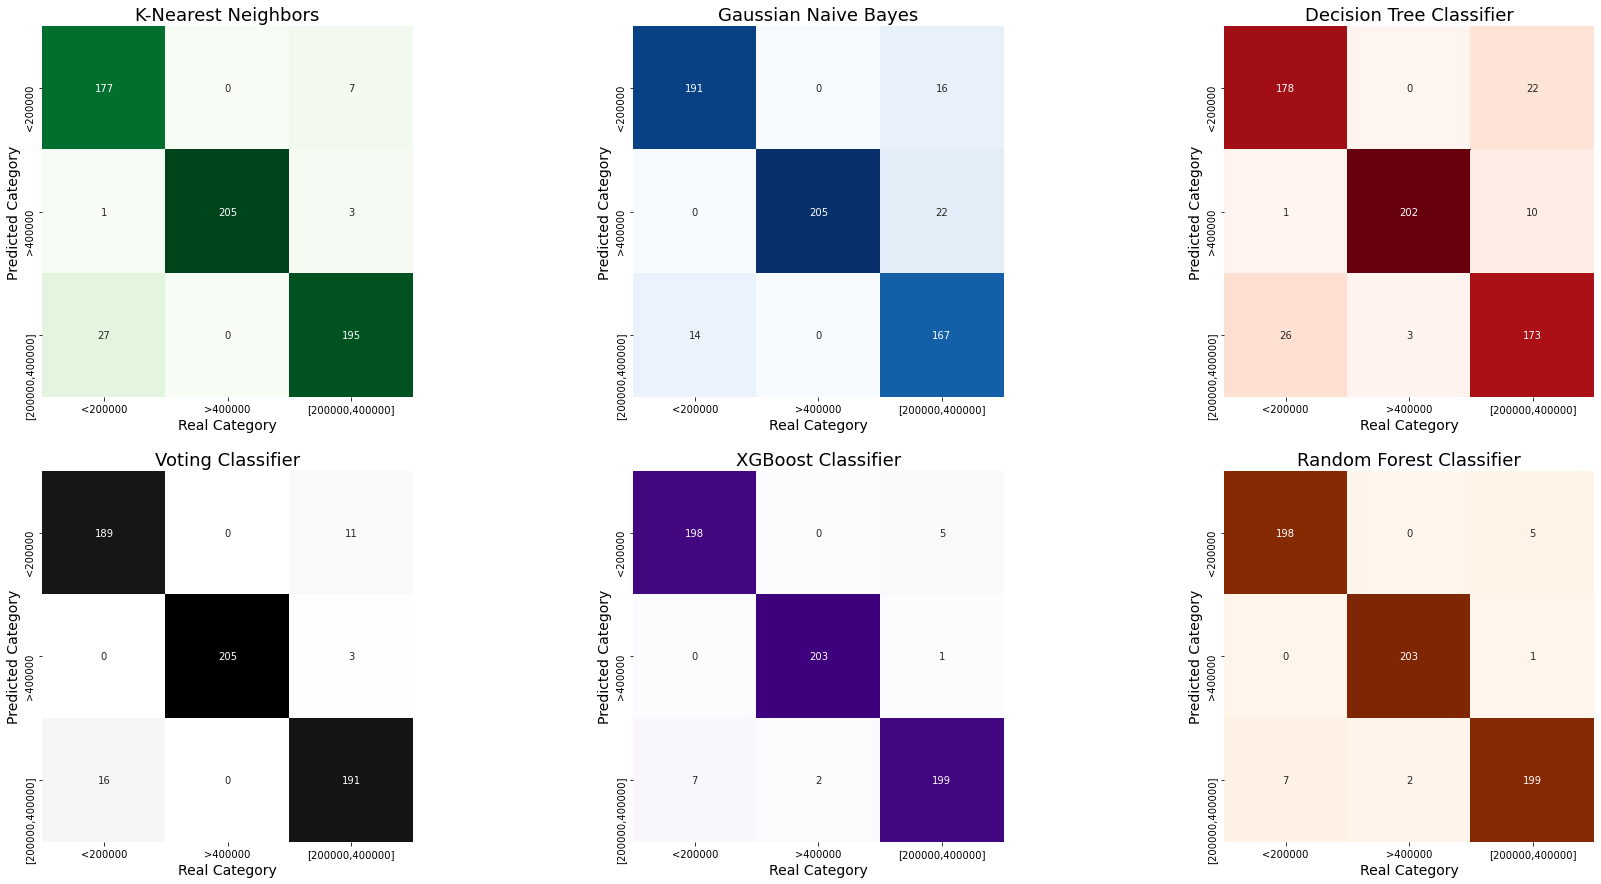

In [182]:
fig = plt.figure(figsize=(30,15))

fig = plt.subplot(2, 3, 1)
cm_test = confusion_matrix(y_test, y_pred_KNN)
sns.heatmap(cm_test.T, cmap='Greens', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('K-Nearest Neighbors', fontsize=18)


fig = plt.subplot(2, 3, 2)
cm_test = confusion_matrix(y_test, y_pred_GNB)
sns.heatmap(cm_test.T, cmap='Blues', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('Gaussian Naive Bayes', fontsize=18)


fig = plt.subplot(2, 3, 3)
cm_test = confusion_matrix(y_test, y_pred_DTC)
sns.heatmap(cm_test.T, cmap='Reds', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('Decision Tree Classifier', fontsize=18)


fig = plt.subplot(2, 3, 4)
cm_test = confusion_matrix(y_test, vot_clas_preds)
sns.heatmap(cm_test.T, cmap='Greys', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('Voting Classifier', fontsize=18)


fig = plt.subplot(2, 3, 5)
cm_test = confusion_matrix(y_test, xgb_class_preds)
sns.heatmap(cm_test.T, cmap='Purples', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('XGBoost Classifier', fontsize=18)


fig = plt.subplot(2, 3, 6)
cm_test = confusion_matrix(y_test, RFC_preds)
sns.heatmap(cm_test.T, cmap='Oranges', square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(class_le.inverse_transform([0, 1, 2])),
            yticklabels=(class_le.inverse_transform([0, 1, 2])))
plt.xlabel('Real Category', fontsize=14)
plt.ylabel('Predicted Category', fontsize=14)
plt.title('Random Forest Classifier', fontsize=18)

plt.show()

In [183]:
print('K-Nearest Neighbors:')
scoring_metrics(y_test, y_pred_KNN)
print('Gaussian Naive Bayes:')
scoring_metrics(y_test, y_pred_GNB)
print('Decision Tree Classifier:')
scoring_metrics(y_test, y_pred_DTC)
print('Voting Classifier scores:')
scoring_metrics(y_test, vot_clas_preds)
print('XGBoost Classifier scores:')
scoring_metrics(y_test, xgb_class_preds)
print('Random Forest Classifier scores:')
scoring_metrics(y_test, RFC_preds)

K-Nearest Neighbors:
Matthews correlation coefficient score (MCC):  0.9087

                  precision    recall  f1-score   support

        <200000       0.96      0.86      0.91       205
        >400000       0.98      1.00      0.99       205
[200000,400000]       0.88      0.95      0.91       205

       accuracy                           0.94       615
      macro avg       0.94      0.94      0.94       615
   weighted avg       0.94      0.94      0.94       615

Gaussian Naive Bayes:
Matthews correlation coefficient score (MCC):  0.8750

                  precision    recall  f1-score   support

        <200000       0.92      0.93      0.93       205
        >400000       0.90      1.00      0.95       205
[200000,400000]       0.92      0.81      0.87       205

       accuracy                           0.92       615
      macro avg       0.92      0.92      0.91       615
   weighted avg       0.92      0.92      0.91       615

Decision Tree Classifier:
Matthews correl

### Individual Classifiers
- Considering the classification algorithms,  `Decision Tree`, `K-Nearest Neighbors` and `Gaussian Naive Bayes`, there are many interesting aspects about the performance of these three algorithms. First of all, they all seem to have an overall good performance with our data. K-Nearest Neighbors seems to have been the algorithm that best classified our data, presenting only 38 mislabeled elements which translates to just over 6% of the test set. To characterize the performance of these algorithms, we used several metrics such as precision and recall. However we relied on Matthews correlation coefficient to qualify its performance. With this metrics in mind we could say that K-Nearest Neighbors had the best performance with an MCC of 0.9087, followed by Gaussian Naive bayes with 0.8750 and lastly the Decision Tree Classifier with 0.8489. Despite these high MCC values and considering the low values of mislabeled elements, an ensemble approach could optimize this classification. 
- The use of Grid Search with Cross Validation proved to be very useful in the search for hyperparameters optimized for the performance of these algorithms.

### Ensemble Classifiers
- In order to understand whether an ensemble approach would increase the quality of our test set classification, we used three ensemble algorithms, `Voting Classifier`, `XGBoost` and `Random Forests`. As with simple classifiers, we try to use a Grid Search approach combined with cross validation. However, the search for parameters proved to be extremely time consuming for these ensemble algorithms. We choose to use a `Randomized Search with Cross Validation` to, in a faster way, look for parameters that would guarantee a good preformance. Considering the initial hypothesis that possibly ensemble algorithms could increase the quality of the predictions, we were not disappointed. Indeed, considering the metrics used previously, the ensemble algorithms managed to make better predictions in all fronts. With MCC values of 0.9634 for both Random Forest and XGBoost and a 0.9269 for the Voting Classifier, this algorithms allowed for better predictions. Interestingly, both the XGBoost and the Random Forest, only mislabeled 15 elements, which translates to less than 2,5% of the objects in the test set. That's amazing!
- Obviously, as mentioned previously, these results have to be taken with a pinch of salt, as our test set should have been produced before the balancing of the different classes. This is a point that could be easily corrected.

## The "Regression Competition"

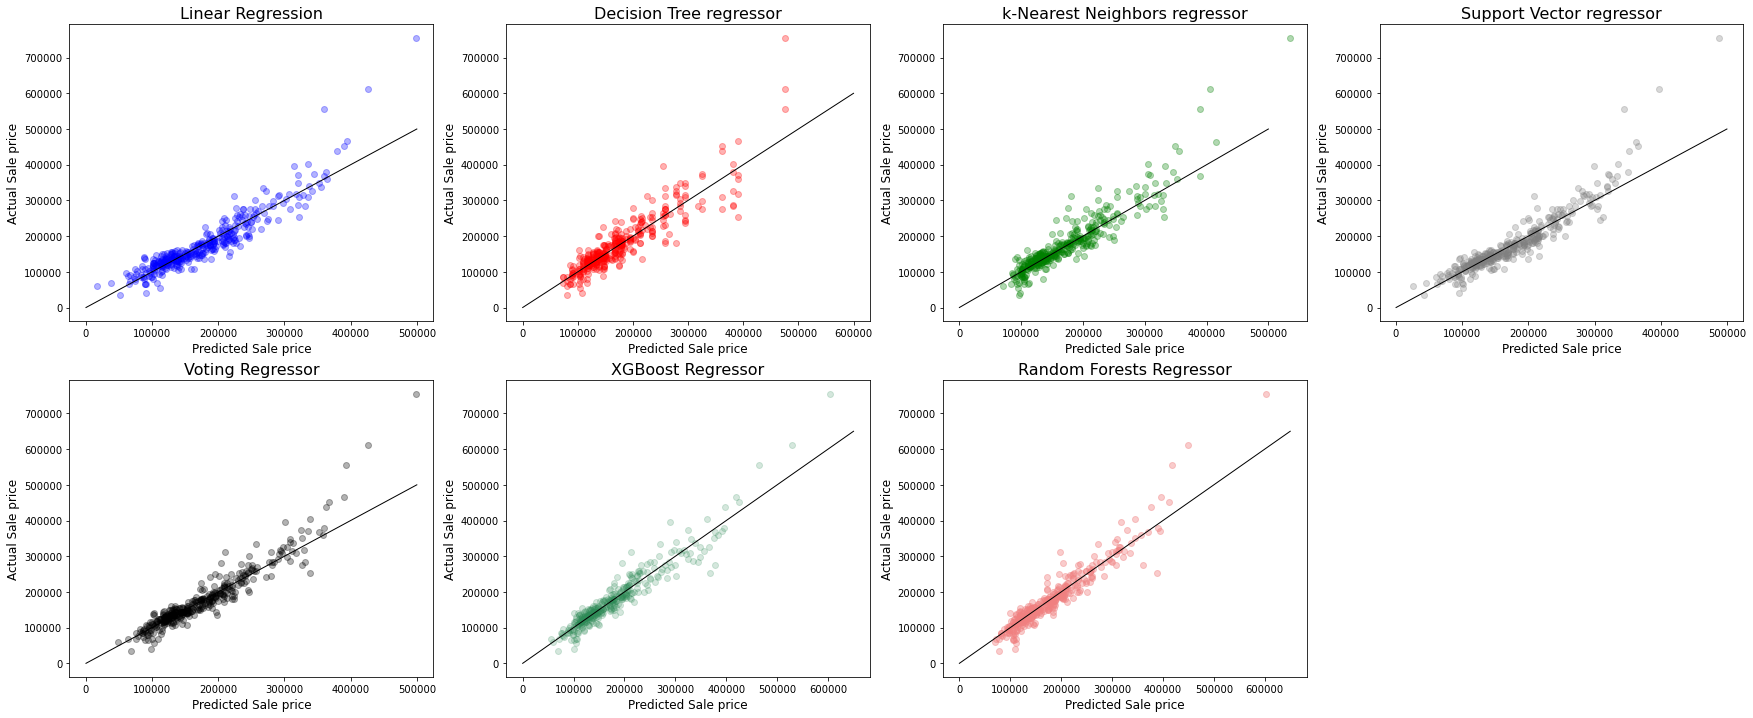

In [175]:
fig = plt.figure(figsize=(30,12))

fig = plt.subplot(2, 4, 1)
plt.scatter(lr_preds, y_test_regression,  color='blue', alpha=0.3)
plt.plot([0,500000], [0, 500000], linestyle="-", lw=1, color="k")
plt.title("Linear Regression", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(2, 4, 2)
plt.scatter(dtr_hyper_preds, y_test_regression,  color='red', alpha=0.3)
plt.plot([0, 600000], [0, 600000], linestyle="-", lw=1, color="k")
plt.title("Decision Tree regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(2, 4, 3)
plt.scatter(knn_hyper_preds, y_test_regression,  color='green', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.title("k-Nearest Neighbors regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(2, 4, 4)
plt.scatter(svr_hyper_preds, y_test_regression,  color='gray', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.title("Support Vector regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(2, 4, 5)

plt.scatter(vot_regression_preds, y_test_regression,  color='black', alpha=0.3)
plt.plot([50,500000], [50, 500000], linestyle="-", lw=1, color="k")
plt.title("Voting Regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(2, 4, 6)
plt.scatter(xgb_regression_preds, y_test_regression,  color='seagreen', alpha=0.2)
plt.plot([50,650000], [50, 650000], linestyle="-", lw=1, color="k")
plt.title("XGBoost Regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

fig = plt.subplot(2, 4, 7)
plt.scatter(RFR_preds, y_test_regression,  color='lightcoral', alpha=0.4)
plt.plot([50,650000], [50,650000], linestyle="-", lw=1, color="k")
plt.title("Random Forests Regressor", fontsize=16)
plt.xlabel('Predicted Sale price', fontsize = 12)
plt.ylabel('Actual Sale price', fontsize = 12)

plt.show()

In [162]:
score_data = {'Linear Regression': [np.sqrt(mean_squared_error(y_test_regression, lr_pred)), mean_squared_error(y_test_regression, lr_pred), mean_absolute_error(y_test_regression, lr_pred), r2_score(y_test_regression, lr_pred)],
        'Decision Trees': [np.sqrt(mean_squared_error(y_test_regression, dtr_hyper_preds)), mean_squared_error(y_test_regression, dtr_hyper_preds), mean_absolute_error(y_test_regression, dtr_hyper_preds), r2_score(y_test_regression, dtr_hyper_preds)],
        'K Nearest Neighbors': [np.sqrt(mean_squared_error(y_test_regression, knn_hyper_preds)), mean_squared_error(y_test_regression, knn_hyper_preds), mean_absolute_error(y_test_regression, knn_hyper_preds), r2_score(y_test_regression, knn_hyper_preds)],
        'Support Vector Regressor': [np.sqrt(mean_squared_error(y_test_regression, svr_hyper_preds)), mean_squared_error(y_test_regression, svr_hyper_preds), mean_absolute_error(y_test_regression, svr_hyper_preds), r2_score(y_test_regression, svr_hyper_preds)],
        'Voting Regressor': [np.sqrt(mean_squared_error(y_test_regression, vot_regression_preds)), mean_squared_error(y_test_regression, vot_regression_preds), mean_absolute_error(y_test_regression, vot_regression_preds), r2_score(y_test_regression, vot_regression_preds)],
        'XGBoost Regressor': [np.sqrt(mean_squared_error(y_test_regression, xgb_regression_preds)), mean_squared_error(y_test_regression, xgb_regression_preds), mean_absolute_error(y_test_regression, xgb_regression_preds), r2_score(y_test_regression, xgb_regression_preds)],
        'Random Forest Regressor': [np.sqrt(mean_squared_error(y_test_regression, RFR_preds)), mean_squared_error(y_test_regression, RFR_preds), mean_absolute_error(y_test_regression, RFR_preds), r2_score(y_test_regression, RFR_preds)]}

df_scores = pd.DataFrame(score_data)
df_scores = df_scores.rename(index={0: 'RMSE', 1: 'MSE', 2: 'MAE', 3: 'R2'})
pd.set_option('display.float_format', '{:.3f}'.format)

df_scores

,Linear Regression,Decision Trees,K Nearest Neighbors,Support Vector Regressor,Voting Regressor,XGBoost Regressor,Random Forest Regressor
RMSE,31036.281,35114.897,32790.822,31684.344,29102.906,25147.928,26267.633
MSE,963250717.588,1233056026.010,1075237986.432,1003897677.566,846979127.748,632418280.768,689988530.789
MAE,20052.154,23036.790,20227.685,18893.997,17107.713,16891.871,16206.803
R2,0.862,0.824,0.847,0.857,0.879,0.910,0.902


### Regressors

- Considering the regressor algorithms, `Decision Tree Regressor`, `K-Nearest Neighbors` and `Linear Regressor`, `Suport Vector Regressor`, an overall good prediction for our data was also obtained. The Linear and Suport Vector Regressor appears to be the best algorithms for our data. To characterize the performance of these algorithms, we use several metrics such as `Root-mean-square deviation` (RMSE), `mean squared error` (MSE) and `mean absolute error` (MAE). However we relyied on `coefficient of determination` (R2) to qualify their performance. 
- Both Linear and support Vector Regressor have the lowest values of RMSE (which indicates low weight of outliers), MSE and MAE, indicating that their predictions are more accurate than the remaining two algorithms. Considering the values for the coefficient of determination, the Linear Regressor and Suport vector Regressor model seems to have the highest value of R2 (0.862 and 0.857, respectively), indicating that these algorithm produces predictive values closer to their actual value. Considering this metric as a regressor models classification, we can assume that the Linear regressor is the best regressor model for our data, followed by the Suport Vector regressor, K-Nearest Neighbors (0.847) and finally, the Decision Tree Regressor (0.824).

### Ensemble Classifiers
- The exercise of Ensemble learning was surprising and exciting in many ways, showing us how powerful these set of techniques can be for predicting values of unknown objects, by learning datasets. We have used three different ensemble approaches for regression (similarly to classification), `Voting Regressor`, `XGBoost Regressor` and a `Random Forest Regressor`. As it can be observed from the scatter plots and metrics above, every single ensemble method outperformed the individual regressors. This goes a great lenght to show something that is logical... many are stronger than one! :)
- The voting regressor, using the best models predicted in the regresion exercise, made a good use of those, improving the overal metrics and efficiency of the model. Nevertheless, the increase in performance that was observed, was not much better than those of the linear regression and suport vector regressor models.
- The best of this project was reserved till the last: the performance of the XGBoost and Random Forest Regressors is indeed, quite an exciting result. Both of these models managed to get very good R2 scores, while lowering the MAE and RMSE errors. Moreover, both of these models manage to get much better predicted values for higher priced houses. This is remarkable, given that the number of houses in the highest prices ranges is very small and, as such, the models seen very few of those objects to learn. 
- For all this, we feel that a few more tweaks of the dataset and the parameters of the models (namely, using `GridSearchCV` to properly parametrize the algorithm), could have provided even better values for the models.